<center><h1>HosseinzadehKhaligh_Ehsan_Final_project</h1></center>

Name: Ehsan Hosseinzadeh Khaligh
<br>
Github Username: ehsankhaligh
<br>
USC ID: 1112811250

##### If you would like to rerun please remove  ../data/SportImages/[testSplit][trainSplit][valSplit][trainParte]
#### To avoid re-run of every cell, I saved models as *.h5 to reuse. however, could not submit on github as size of them is big. rerunning the whole notebook will regenrate them under /notebook folder

Import packages

In [1]:
#from google.colab import drive
#drive.mount("/content/drive")

In [2]:
#!pip install -U scikit-learn
#!python -m pip install -U matplotlib
#!pip install pandas

import random
import math
import shutil
import cv2
import os
import time
import sys
import time
import h5py
import shutil
import subprocess

import urllib.request
import numpy as np
from PIL import Image

import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix, classification_report
from keras.applications.efficientnet import EfficientNetB0
from keras.applications.vgg16 import VGG16
from tensorflow.keras.models import load_model
from tensorflow.keras.models import load_model

import warnings
warnings.filterwarnings('ignore')

### a,b,c -> Explanation only

### d

##### i. Images in each class are given in separate folders in the folder Sport Images. We have several hundreds of images for five classes of sport activities, namely baseball, basketball, fencing, tennis, and volleyball.
##### ii. Randomly select ⌈0.7ni⌉ images from each folder as your training set, ⌈0.15ni⌉ as validation set, and the rest as your test set, where ni is the number of images in folder i and ⌈x⌉ is the ceiling of x.
#####  iii. In order for all the images to have the same size, zero-pad or resize the images in your dataset. This can be done using various tools, including OpenCV.

In [3]:
!pwd
#!ls /content/drive/MyDrive/colab/finalProject/data/SportImages/
!ls ../data

/Users/ehsanmacpro2022/Desktop/DSCI552/Homwrorks/finalProject/notebook
SportImages SportVideos


In [4]:
# Set the path to the folder containing the subfolders of images
#data_dir = "/content/drive/MyDrive/colab/finalProject/data/SportImages"
data_dir = "../data/SportImages"

# Set the percentages for training, validation, and test sets
train_percent = 0.7
val_percent = 0.15
test_percent = 0.15

In [5]:
def resizeWrite(src_path, xxx_folder):
        resize_img = None
                
        if '.gif' in src_path:

            # Create the output file path
            base_name, _ = os.path.splitext(src_path)
            dst_path = base_name + ".jpg"

            Image.open(src_path).convert('RGB').save(dst_path)
            src_path = dst_path

        # Load the image
        resize_img = cv2.imread(src_path)

        # Resize or pad the image to the desired size
        h, w, _ = resize_img.shape
        if h > w:
            # Pad the width to match the height
            pad_size = (h - w) // 2
            resize_img = cv2.copyMakeBorder(resize_img, 0, 0, pad_size, pad_size, cv2.BORDER_CONSTANT, value=(0, 0, 0))
        else:
            # Pad the height to match the width
            pad_size = (w - h) // 2
            resize_img = cv2.copyMakeBorder(resize_img, pad_size, pad_size, 0, 0, cv2.BORDER_CONSTANT, value=(0, 0, 0))

        # Resize the image to the desired size
        resize_img = cv2.resize(resize_img, img_size)

        # Save the resized or padded image
        dst_path = os.path.join(xxx_folder, img)

        if '.gif' in dst_path:
            base_name, _ = os.path.splitext(dst_path)
            dst_path = base_name + ".jpg"

        cv2.imwrite(dst_path, resize_img)

In [6]:
os.makedirs("../data/SportImages/trainSplit", exist_ok=True)
os.makedirs("../data/SportImages/testSplit", exist_ok=True)
os.makedirs("../data/SportImages/valSplit", exist_ok=True)

for class_folder in os.listdir(data_dir):
    if ".DS_Store" in class_folder:
        pass
    else:  
        
        
        if (('testSplit' in class_folder)or('trainSplit' in class_folder)or('valSplit' in class_folder)):
            continue 

        print(class_folder)
        train_data_dir =  '../data/SportImages/trainSplit'
        valid_data_dir ='../data/SportImages/valSplit'
        test_data_dir ='../data/SportImages/testSplit'

        # Create the necessary subfolders for each set
        train_folder = os.path.join(train_data_dir, class_folder + "_train")
        val_folder = os.path.join(valid_data_dir, class_folder + "_val")
        test_folder = os.path.join(test_data_dir, class_folder + "_test")
        #print(train_folder)
        #print(val_folder)
        #print(test_folder)

        os.makedirs(train_folder, exist_ok=True)
        os.makedirs(val_folder, exist_ok=True)
        os.makedirs(test_folder, exist_ok=True)
        
        # Get the list of images in the current class folder
        images = os.listdir(os.path.join(data_dir, class_folder))
        #print(images)
        num_images = len(images)
        print("num_images:" + str(num_images))
        
        
        # Calculate the number of images for each set based on the provided percentages
        num_train = math.ceil(train_percent * num_images)
        num_val = math.ceil(val_percent * num_images)
        num_test = num_images - num_train - num_val
        
        #print("num_train:", num_train)
        #print("num_val:", num_val)
        #print("num_test:", num_test)
        
        
        # Randomly select the images for each set
        random.shuffle(images)
        train_images = images[:num_train]
        val_images = images[num_train:num_train+num_val]
        test_images = images[num_train+num_val:] 

        image_formats = [".jpg", ".jpeg", ".png", ".gif", ".bmp", ".tif", ".tiff", ".svg"]
        img_size = (224, 224)
        
        # Copy the images to their respective set folders
        for img in train_images:
            src_path = os.path.join(data_dir, class_folder, img)
            #print(src_path)
            
            if os.path.splitext(src_path)[-1].lower() in image_formats:
                resizeWrite(src_path, train_folder)
            else:
                pass
            
        for img in val_images:
            src_path = os.path.join(data_dir, class_folder, img)
            #print(src_path)
            
            if os.path.splitext(src_path)[-1].lower() in image_formats:
                resizeWrite(src_path, val_folder)
            else:
                pass
            
        for img in test_images:
            src_path = os.path.join(data_dir, class_folder, img)
            #print(src_path)
            
            if os.path.splitext(src_path)[-1].lower() in image_formats:
                resizeWrite(src_path, test_folder)
            else:
                pass
        print()


baseball
num_images:738


libpng warning: iCCP: known incorrect sRGB profile



basketball
num_images:494


libpng warning: iCCP: known incorrect sRGB profile



volleyball
num_images:705


libpng warning: iCCP: known incorrect sRGB profile



fencing
num_images:644


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile



tennis
num_images:716


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


## e

##### ii. To perform empirical regularization, crop, randomly zoom, rotate, flip, con- trast, and translate images in your training set for image augmentation. You can use various tools to do this, including OpenCV.

#### iii. Use ReLU activation functions in the last layer and a softmax layer, along with batch normalization 4 and a dropout rate of 20% as well as ADAM optimizer. Use multinomial cross entropy loss. You can try any batch size, but a batch size of 5 seems reasonable.

#### iv. Train the networks ResNet50, EfficientNetB0, and VGG16 for at least 50 epochs (preferably 100 epochs) and perform early stopping using the valida- tion set. Keep the network parameters that have the lowest validation error. Plot the training and validation errors vs. epochs.

#### v. Report the Confusion Matrix, Precision, Recall, Accuracy, and F1 score for your model on both training and test sets. Remember that this is a multi-class classification problem.

In [7]:
start_time = time.time()

#train_data_dir =  '/content/drive/MyDrive/colab/finalProject/data/SportImages/trainSplit'
#valid_data_dir ='/content/drive/MyDrive/colab/finalProject/data/SportImages/valSplit'
#test_data_dir ='/content/drive/MyDrive/colab/finalProject/data/SportImages/testSplit'

train_data_dir =  '../data/SportImages/trainSplit'
valid_data_dir ='../data/SportImages/valSplit'
test_data_dir ='../data/SportImages/testSplit'

#!ls /content/drive/MyDrive/colab/finalProject/data/SportImages/trainSplit
#!echo ""
#!ls /content/drive/MyDrive/colab/finalProject/notebook
#!echo ""
#!ls /content/drive/MyDrive/colab/finalProject/data/SportImages/testSplit

!ls ../data/SportImages/trainSplit
!echo ""
!ls ../data/SportImages/testSplit

baseball_train   fencing_train    volleyball_train
basketball_train tennis_train

baseball_test   basketball_test fencing_test    tennis_test     volleyball_test


### ResNet50


In [31]:
#check number categories 

#mytrain_generator = train_datagen.flow_from_directory(
#    train_data_dir,
#    target_size=(224, 224),
#    batch_size=5,
#    class_mode='categorical'
#)

#print(mytrain_generator.class_indices)
#{'baseball_train': 0, 'basketball_train': 1, 'fencing_train': 2, 'tennis_train': 3, 'volleyball_train': 4}

Found 2299 images belonging to 5 classes.
Found 496 images belonging to 5 classes.
Epoch 1/50


2023-05-06 23:53:39.735470: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


460/460 [==============================] - 247s 527ms/step - loss: 1.7349 - accuracy: 0.2732 - val_loss: 1.9375 - val_accuracy: 0.2238
Epoch 2/50
460/460 [==============================] - 243s 529ms/step - loss: 1.6721 - accuracy: 0.2627 - val_loss: 1.7830 - val_accuracy: 0.2661
Epoch 3/50
460/460 [==============================] - 242s 525ms/step - loss: 1.5651 - accuracy: 0.3001 - val_loss: 2.4987 - val_accuracy: 0.3548
Epoch 4/50
460/460 [==============================] - 241s 525ms/step - loss: 1.5630 - accuracy: 0.3123 - val_loss: 2.1301 - val_accuracy: 0.3770
Epoch 5/50
460/460 [==============================] - 241s 524ms/step - loss: 1.5758 - accuracy: 0.2893 - val_loss: 95.0315 - val_accuracy: 0.1452
Epoch 6/50
460/460 [==============================] - 250s 543ms/step - loss: 1.5593 - accuracy: 0.2932 - val_loss: 2.8661 - val_accuracy: 0.3044
Epoch 7/50
460/460 [==============================] - 253s 549ms/step - loss: 1.5434 - accuracy: 0.3127 - val_loss: 1.4130 - val_accur

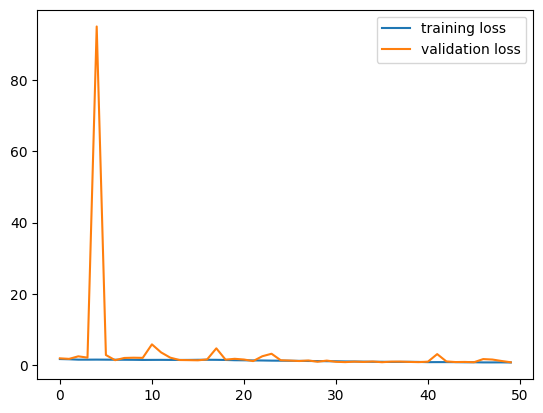

In [8]:

# this is the augmentation configuration we will use for training
train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

# this is the augmentation configuration we will use for testing:
# only rescaling
validation_datagen = ImageDataGenerator(rescale=1. / 255)

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(224, 224),
    batch_size=5,
    class_mode='categorical')



validation_generator = validation_datagen.flow_from_directory(
    valid_data_dir,
    target_size=(224, 224),
    batch_size=5,
    class_mode='categorical')

# Model definition
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dropout(0.2)(x)
predictions = Dense(len(train_generator.class_indices), activation='softmax')(x)
model = tf.keras.Model(inputs=base_model.input, outputs=predictions)

# Model compilation
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Early stopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)


# Model training
history = model.fit(train_generator, epochs=50, validation_data=validation_generator, callbacks=[es])

# Save the model to a file
#model.save('/content/drive/MyDrive/colab/finalProject/notebook/ResNet50.h5')
model.save('ResNet50.h5')

# Plotting training and validation loss
plt.plot(history.history['loss'], label='training loss')
plt.plot(history.history['val_loss'], label='validation loss')
plt.legend()
plt.show()


In [9]:
# Evaluation on training set
train_steps = train_generator.n // train_generator.batch_size
train_preds = model.predict(train_generator, verbose=1, steps=train_generator.samples)
train_labels = train_generator.classes

train_cm = confusion_matrix(train_labels, train_preds.argmax(axis=1))
train_cr = classification_report(train_labels, train_preds.argmax(axis=1), target_names=list(train_generator.class_indices.keys()))
print("Training confusion matrix:\n", train_cm)
print("Training classification report:\n", train_cr)

# Evaluation on test set
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    test_data_dir,
    target_size=(224, 224),
    batch_size=5,
    class_mode='categorical')
test_steps = test_generator.n // test_generator.batch_size
test_preds = model.predict(test_generator, verbose=1, steps=train_generator.samples)
test_labels = test_generator.classes

# Evaluation on testing set
test_steps = test_generator.n // test_generator.batch_size
test_preds = model.predict(test_generator, verbose=1, steps=test_generator.samples)
test_labels = test_generator.classes

test_cm = confusion_matrix(test_labels, test_preds.argmax(axis=1))
test_cr = classification_report(test_labels, test_preds.argmax(axis=1), target_names=list(test_generator.class_indices.keys()))
print("testing confusion matrix:\n", test_cm)
print("testing classification report:\n", test_cr)

2299/2299 [==============================] - 68s 29ms/step
Training confusion matrix:
 [[ 89  35 129 107 154]
 [ 71  34  69  80  92]
 [ 67  40 110  98 129]
 [ 89  45 115 115 137]
 [ 78  48  96 123 149]]
Training classification report:
                   precision    recall  f1-score   support

  baseball_train       0.23      0.17      0.20       514
basketball_train       0.17      0.10      0.12       346
   fencing_train       0.21      0.25      0.23       444
    tennis_train       0.22      0.23      0.22       501
volleyball_train       0.23      0.30      0.26       494

        accuracy                           0.22      2299
       macro avg       0.21      0.21      0.21      2299
    weighted avg       0.21      0.22      0.21      2299

Found 490 images belonging to 5 classes.
490/490 [==============================] - 15s 29ms/step
testing confusion matrix:
 [[15 10 25 28 32]
 [12  4 19 13 25]
 [19  8 25 22 22]
 [18  4 23 30 31]
 [16  4 17 23 45]]
testing classification 

### EfficientNetB0 


Found 2299 images belonging to 5 classes.
Found 496 images belonging to 5 classes.
Epoch 1/50
460/460 [==============================] - 114s 236ms/step - loss: 1.3098 - accuracy: 0.5502 - val_loss: 3.4446 - val_accuracy: 0.2984
Epoch 2/50
460/460 [==============================] - 107s 233ms/step - loss: 1.1141 - accuracy: 0.6111 - val_loss: 22817.5234 - val_accuracy: 0.2238
Epoch 3/50
460/460 [==============================] - 107s 234ms/step - loss: 0.9228 - accuracy: 0.6768 - val_loss: 8.2632 - val_accuracy: 0.1895
Epoch 4/50
460/460 [==============================] - 109s 236ms/step - loss: 0.8809 - accuracy: 0.6890 - val_loss: 8.5387 - val_accuracy: 0.2198
Epoch 5/50
460/460 [==============================] - 108s 236ms/step - loss: 0.7621 - accuracy: 0.7408 - val_loss: 5.0497 - val_accuracy: 0.2218
Epoch 6/50
460/460 [==============================] - 107s 233ms/step - loss: 0.6877 - accuracy: 0.7603 - val_loss: 14.8593 - val_accuracy: 0.2359
Epoch 7/50
460/460 [================

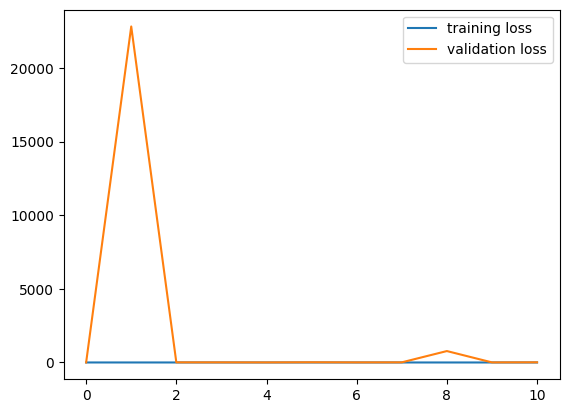

In [10]:
# this is the augmentation configuration we will use for training
train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

# this is the augmentation configuration we will use for testing:
# only rescaling
validation_datagen = ImageDataGenerator(rescale=1. / 255)

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(224, 224),
    batch_size=5,
    class_mode='categorical')



validation_generator = validation_datagen.flow_from_directory(
    valid_data_dir,
    target_size=(224, 224),
    batch_size=5,
    class_mode='categorical')

# Model definition
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dropout(0.2)(x)
predictions = Dense(len(train_generator.class_indices), activation='softmax')(x)
efficientNetB0model = tf.keras.Model(inputs=base_model.input, outputs=predictions)

# Model compilation
efficientNetB0model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Early stopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)


# Model training
history = efficientNetB0model.fit(train_generator, epochs=50, validation_data=validation_generator, callbacks=[es])

# Save the model to a file
#efficientNetB0model.save('/content/drive/MyDrive/colab/finalProject/notebook/EfficientNetB0.h5') issue: https://github.com/keras-team/keras/issues/17199
# Convert the tensor to a numpy array
train_preds = np.array(train_preds)
#np.save('/content/drive/MyDrive/colab/finalProject/notebook/EfficientNetB0.npy', train_preds)
#np.save('EfficientNetB0.npy', train_preds) did not work

# Plotting training and validation loss
plt.plot(history.history['loss'], label='training loss')
plt.plot(history.history['val_loss'], label='validation loss')
plt.legend()
plt.show()

In [11]:
# Evaluation on training set
train_steps = train_generator.n // train_generator.batch_size
train_preds = model.predict(train_generator, verbose=1, steps=train_generator.samples)
train_labels = train_generator.classes

train_cm = confusion_matrix(train_labels, train_preds.argmax(axis=1))
train_cr = classification_report(train_labels, train_preds.argmax(axis=1), target_names=list(train_generator.class_indices.keys()))
print("Training confusion matrix:\n", train_cm)
print("Training classification report:\n", train_cr)

# Evaluation on test set
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    test_data_dir,
    target_size=(224, 224),
    batch_size=5,
    class_mode='categorical')
test_steps = test_generator.n // test_generator.batch_size
test_preds = model.predict(test_generator, verbose=1, steps=train_generator.samples)
test_labels = test_generator.classes

# Evaluation on testing set
test_steps = test_generator.n // test_generator.batch_size
test_preds = model.predict(test_generator, verbose=1, steps=test_generator.samples)
test_labels = test_generator.classes

test_cm = confusion_matrix(test_labels, test_preds.argmax(axis=1))
test_cr = classification_report(test_labels, test_preds.argmax(axis=1), target_names=list(test_generator.class_indices.keys()))
print("testing confusion matrix:\n", test_cm)
print("testing classification report:\n", test_cr)

2299/2299 [==============================] - 63s 27ms/step
Training confusion matrix:
 [[ 84  38 110 122 160]
 [ 73  24  75  81  93]
 [ 83  37  84 112 128]
 [ 80  48 115 123 135]
 [ 72  47 116 110 149]]
Training classification report:
                   precision    recall  f1-score   support

  baseball_train       0.21      0.16      0.19       514
basketball_train       0.12      0.07      0.09       346
   fencing_train       0.17      0.19      0.18       444
    tennis_train       0.22      0.25      0.23       501
volleyball_train       0.22      0.30      0.26       494

        accuracy                           0.20      2299
       macro avg       0.19      0.19      0.19      2299
    weighted avg       0.20      0.20      0.20      2299

Found 490 images belonging to 5 classes.
490/490 [==============================] - 13s 27ms/step
testing confusion matrix:
 [[ 9  6 32 30 33]
 [13  4 19 15 22]
 [11  4 16 27 38]
 [28 10 22 21 25]
 [19  6 20 23 37]]
testing classification 

### VGG16 

Found 2299 images belonging to 5 classes.
Found 496 images belonging to 5 classes.
Epoch 1/50
460/460 [==============================] - 499s 1s/step - loss: 1.5875 - accuracy: 0.2910 - val_loss: 2.4443 - val_accuracy: 0.2319
Epoch 2/50
460/460 [==============================] - 497s 1s/step - loss: 1.5128 - accuracy: 0.3349 - val_loss: 1.8312 - val_accuracy: 0.2601
Epoch 3/50
460/460 [==============================] - 497s 1s/step - loss: 1.4756 - accuracy: 0.3515 - val_loss: 1.4967 - val_accuracy: 0.3548
Epoch 4/50
460/460 [==============================] - 496s 1s/step - loss: 1.4462 - accuracy: 0.3362 - val_loss: 1.5814 - val_accuracy: 0.3790
Epoch 5/50
460/460 [==============================] - 496s 1s/step - loss: 1.4043 - accuracy: 0.3667 - val_loss: 1.7114 - val_accuracy: 0.2964
Epoch 6/50
460/460 [==============================] - 496s 1s/step - loss: 1.4095 - accuracy: 0.3723 - val_loss: 1.3948 - val_accuracy: 0.3831
Epoch 7/50
460/460 [==============================] - 496s 

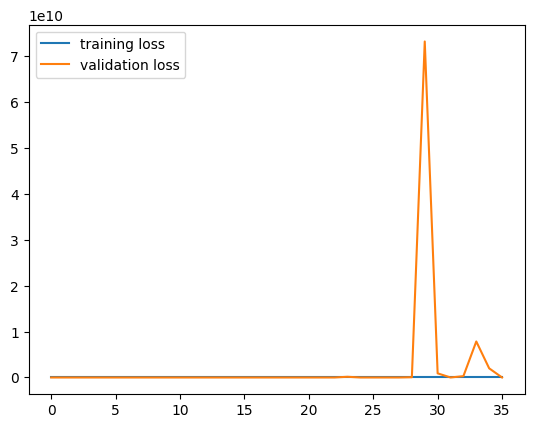

In [12]:

# this is the augmentation configuration we will use for training
train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

# this is the augmentation configuration we will use for testing:
# only rescaling
validation_datagen = ImageDataGenerator(rescale=1. / 255)

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(224, 224),
    batch_size=5,
    class_mode='categorical')


validation_generator = validation_datagen.flow_from_directory(
    valid_data_dir,
    target_size=(224, 224),
    batch_size=5,
    class_mode='categorical')

# Model definition
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dropout(0.2)(x)
predictions = Dense(len(train_generator.class_indices), activation='softmax')(x)
model = tf.keras.Model(inputs=base_model.input, outputs=predictions)

# Model compilation
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Early stopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)


# Model training
history = model.fit(train_generator, epochs=50, validation_data=validation_generator, callbacks=[es])

# Save the model to a file
#model.save('/content/drive/MyDrive/colab/finalProject/notebook/VGG16.h5')
model.save('VGG16.h5')

# Plotting training and validation loss
plt.plot(history.history['loss'], label='training loss')
plt.plot(history.history['val_loss'], label='validation loss')
plt.legend()
plt.show()

In [13]:
# Evaluation on training set
train_steps = train_generator.n // train_generator.batch_size
train_preds = model.predict(train_generator, verbose=1, steps=train_generator.samples)
train_labels = train_generator.classes

train_cm = confusion_matrix(train_labels, train_preds.argmax(axis=1))
train_cr = classification_report(train_labels, train_preds.argmax(axis=1), target_names=list(train_generator.class_indices.keys()))
print("Training confusion matrix:\n", train_cm)
print("Training classification report:\n", train_cr)

# Evaluation on test set
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    test_data_dir,
    target_size=(224, 224),
    batch_size=5,
    class_mode='categorical')
test_steps = test_generator.n // test_generator.batch_size
test_preds = model.predict(test_generator, verbose=1, steps=train_generator.samples)
test_labels = test_generator.classes

# Evaluation on testing set
test_steps = test_generator.n // test_generator.batch_size
test_preds = model.predict(test_generator, verbose=1, steps=test_generator.samples)
test_labels = test_generator.classes

test_cm = confusion_matrix(test_labels, test_preds.argmax(axis=1))
test_cr = classification_report(test_labels, test_preds.argmax(axis=1), target_names=list(test_generator.class_indices.keys()))
print("testing confusion matrix:\n", test_cm)
print("testing classification report:\n", test_cr)

print ("My program took", time.time() - start_time, "to run")


2299/2299 [==============================] - 135s 59ms/step
Training confusion matrix:
 [[ 94 206  53 127  34]
 [ 68 126  44  70  38]
 [ 75 179  52 109  29]
 [ 70 180  71 133  47]
 [ 87 173  60 133  41]]
Training classification report:
                   precision    recall  f1-score   support

  baseball_train       0.24      0.18      0.21       514
basketball_train       0.15      0.36      0.21       346
   fencing_train       0.19      0.12      0.14       444
    tennis_train       0.23      0.27      0.25       501
volleyball_train       0.22      0.08      0.12       494

        accuracy                           0.19      2299
       macro avg       0.20      0.20      0.19      2299
    weighted avg       0.21      0.19      0.19      2299

Found 490 images belonging to 5 classes.
490/490 [==============================] - 29s 58ms/step
testing confusion matrix:
 [[12 46 15 27 10]
 [12 26  9 17  9]
 [15 39 12 18 12]
 [17 44 13 23  9]
 [22 35 10 24 14]]
testing classification

### f

#### i. In order to have a better deep learner, reuse the validation and test data and train the network, without seriously overfitting it. In the lectures, we saw how this can be done.

#### ii. Apply at least L equally spaced frames of each video in the folder Sport Videos5 to your model to obtain L vectors of probability predictions from the softmax in your model. You must choose L to be at least 100, but you are welcome to use all the frames in each video. Calculate the average p ̄ of these probability vectors for each video.

#### iii. Select the class with maximum probability in the vector p ̄ for each video and compare it to the actual label of the video.

#### iv. Report the Confusion Matrix, Precision, Recall, Accuracy, and F1 score for your model on the test data, i.e. videos. Remember that this is a multi-class classification problem

In [14]:
!PWD
!echo ""
!ls ../data/SportImages/valSplit
!echo ""
!ls ../data/SportImages/testSplit


/Users/ehsanmacpro2022/Desktop/DSCI552/Homwrorks/finalProject/notebook

baseball_val   basketball_val fencing_val    tennis_val     volleyball_val

baseball_test   basketball_test fencing_test    tennis_test     volleyball_test


In [15]:
# merge test and validation data to retrain 

valid_data_dir = '../data/SportImages/valSplit'
test_data_dir ='../data/SportImages/testSplit'

os.makedirs("../data/SportImages/trainParte", exist_ok=True)

val_list_dirs = ['baseball_val', 'basketball_val', 'fencing_val', 'tennis_val', 'volleyball_val']
test_list_dirs = ['baseball_test', 'basketball_test', 'fencing_test', 'tennis_test', 'volleyball_test']

for val,test in zip(val_list_dirs,test_list_dirs):

    dir_name_create = val.split('_')[0]
    os.makedirs("../data/SportImages/trainParte/" + dir_name_create, exist_ok=True)
    
    new_copy_path = "../data/SportImages/trainParte/" + dir_name_create
    source1 = '../data/SportImages/valSplit/' + val
    source2 ='../data/SportImages/testSplit/' + test
    
    cmd1 = 'cp ' + source1 + '/* ' + new_copy_path
    cmd2 = 'cp ' + source2 + '/* ' + new_copy_path

    subprocess.run(cmd1 , shell=True)
    subprocess.run(cmd2 , shell=True)

### ResNet50.h5

In [16]:
model = load_model('ResNet50.h5')
new_data_path = '../data/SportImages/trainParte'
data_generator = ImageDataGenerator(rescale=1./255)
new_data_generator = data_generator.flow_from_directory(
    new_data_path,
    target_size=(224, 224),
    batch_size=5,
    class_mode='categorical'
)
model.fit(
    new_data_generator,
    epochs=50,  
)

model.save('ResNet50_v2.h5')

Found 985 images belonging to 5 classes.
Epoch 1/50
197/197 [==============================] - 95s 464ms/step - loss: 0.8483 - accuracy: 0.6843
Epoch 2/50
197/197 [==============================] - 90s 458ms/step - loss: 0.8113 - accuracy: 0.7096
Epoch 3/50
197/197 [==============================] - 90s 459ms/step - loss: 0.7779 - accuracy: 0.7208
Epoch 4/50
197/197 [==============================] - 90s 455ms/step - loss: 0.6938 - accuracy: 0.7594
Epoch 5/50
197/197 [==============================] - 91s 460ms/step - loss: 0.7232 - accuracy: 0.7431
Epoch 6/50
197/197 [==============================] - 91s 460ms/step - loss: 0.6267 - accuracy: 0.7858
Epoch 7/50
197/197 [==============================] - 90s 459ms/step - loss: 0.5602 - accuracy: 0.8061
Epoch 8/50
197/197 [==============================] - 90s 457ms/step - loss: 0.5617 - accuracy: 0.7980
Epoch 9/50
197/197 [==============================] - 90s 458ms/step - loss: 0.4580 - accuracy: 0.8579
Epoch 10/50
197/197 [===========

### EfficientNetB0¶

In [17]:
model = efficientNetB0model 

new_data_path = '../data/SportImages/trainParte'
data_generator = ImageDataGenerator(rescale=1./255)
new_data_generator = data_generator.flow_from_directory(
    new_data_path,
    target_size=(224, 224),
    batch_size=5,
    class_mode='categorical'
)
model.fit(
    new_data_generator,
    epochs=50,  
)

efficientNetB0model_v2 = model

#Keras has a bug and does not allow to save efficientNetB0.h5

Found 985 images belonging to 5 classes.
Epoch 1/50
197/197 [==============================] - 41s 209ms/step - loss: 0.7478 - accuracy: 0.7442
Epoch 2/50
197/197 [==============================] - 42s 212ms/step - loss: 0.4962 - accuracy: 0.8264
Epoch 3/50
197/197 [==============================] - 41s 209ms/step - loss: 0.4374 - accuracy: 0.8325
Epoch 4/50
197/197 [==============================] - 40s 205ms/step - loss: 0.5805 - accuracy: 0.7939
Epoch 5/50
197/197 [==============================] - 41s 207ms/step - loss: 0.4713 - accuracy: 0.8457
Epoch 6/50
197/197 [==============================] - 41s 209ms/step - loss: 0.3395 - accuracy: 0.8924
Epoch 7/50
197/197 [==============================] - 41s 208ms/step - loss: 0.3733 - accuracy: 0.8772
Epoch 8/50
197/197 [==============================] - 41s 210ms/step - loss: 0.3833 - accuracy: 0.8660
Epoch 9/50
197/197 [==============================] - 41s 210ms/step - loss: 0.4198 - accuracy: 0.8558
Epoch 10/50
197/197 [===========

### VGG16 

In [18]:
model = load_model('VGG16.h5')
new_data_path = '../data/SportImages/trainParte'
data_generator = ImageDataGenerator(rescale=1./255)
new_data_generator = data_generator.flow_from_directory(
    new_data_path,
    target_size=(224, 224),
    batch_size=5,
    class_mode='categorical'
)
model.fit(
    new_data_generator,
    epochs=50,  
)

model.save('VGG16_v2.h5')

Found 985 images belonging to 5 classes.
Epoch 1/50
197/197 [==============================] - 201s 1s/step - loss: 1.1034 - accuracy: 0.5939
Epoch 2/50
197/197 [==============================] - 201s 1s/step - loss: 0.9989 - accuracy: 0.6315
Epoch 3/50
197/197 [==============================] - 200s 1s/step - loss: 0.9761 - accuracy: 0.6416
Epoch 4/50
197/197 [==============================] - 201s 1s/step - loss: 0.9857 - accuracy: 0.6467
Epoch 5/50
197/197 [==============================] - 201s 1s/step - loss: 1.0161 - accuracy: 0.6234
Epoch 6/50
197/197 [==============================] - 200s 1s/step - loss: 0.9449 - accuracy: 0.6660
Epoch 7/50
197/197 [==============================] - 200s 1s/step - loss: 0.9240 - accuracy: 0.6731
Epoch 8/50
197/197 [==============================] - 200s 1s/step - loss: 0.8864 - accuracy: 0.6954
Epoch 9/50
197/197 [==============================] - 200s 1s/step - loss: 0.8574 - accuracy: 0.6924
Epoch 10/50
197/197 [=============================

In [26]:
def videofeed(model):
    # Define the number of frames to sample from each video
    num_frames = 100
    # Define a dictionary to store the average probability vectors for each video
    video_probs = {}
    myvideo_probs = {} #after inner for loop

    # Define a dictionary to store the predicted classes for each video
    myvideo_predictions = {}

    # Loop through each subfolder in the SportVideos folder
    #baseball fencing volleyball basketball tennis -> in order
    for category in ['BaseballPitch', 'Fencing','VolleyballSpiking',  'Basketball', 'TennisSwing']:

        # Initialize an empty list to store the probability vectors for each video
        video_probs[category] = []

        # Initialize an empty list to store the probability vectors for each video
        prob_list = []
        pred_list = []

        path = "../data/SportVideos/" + category
        dir_list = os.listdir(path)
        #print(dir_list)  

        # Loop through each video file in the subfolder
        for i in dir_list:

            # Read the video file using OpenCV
            video_path = path+'/'+i

            if '.DS_Store' in video_path:
                continue
            else:
                print(video_path)
            cap = cv2.VideoCapture(video_path)

            # Initialize an empty list to store the frames
            frames = []

            # Loop through L equally spaced frames in the video
            for j in range(num_frames):

                # Set the frame index to read
                frame_idx = int(cap.get(cv2.CAP_PROP_FRAME_COUNT) * j / num_frames)

                # Read the frame and resize it to (224, 224) for the model
                ret, frame = cap.read()
                if not ret:
                    break
                frame = cv2.resize(frame, (224, 224))

                # Normalize the pixel values to [0, 1]
                frame = frame / 255.0

                # Add the frame to the list
                frames.append(frame)

            # If the video has less than L frames, pad the list with the last frame
            while len(frames) < num_frames:
                frames.append(frames[-1])

            # Convert the list of frames to a NumPy array
            frames = np.array(frames)

            # Predict the probability vectors using the model
            probs = model.predict(frames)

            # Calculate the average probability vector and append it to the list

            avg_prob = np.mean(probs, axis=0)
            print("probs shape:", probs.shape)
            print("avg_prob:", avg_prob)
            new_values = np.array(avg_prob)

            #max item from avg_prob_prediction 
            pred_class = np.argmax(avg_prob)
            print("pred_class:", pred_class)

            # Append the average probability vector and predicted class to the lists
            prob_list.append(avg_prob)
            pred_list.append(pred_class)

            #print("before video_probs:", video_probs)
            video_probs[category] = [np.concatenate((video_probs[category], new_values))]        
            #print("after video_probs:", video_probs)

            # Release the video capture object
            cap.release()

            # Convert the list of average probability vectors to a NumPy array
            video_probs[category] = np.concatenate(video_probs[category], axis=0)
            #print("second after video_probs:", video_probs)

            # Calculate the overall average probability vector for the subfolder after each video read
            avg_prob = np.mean(video_probs[category], axis=0)

            # Print the overall average probability vector for the subfolder
            print(f'Concat all probs avg upto this iteration for {category}: {avg_prob}')

            print("*"*15)

        # Convert the list of average probability vectors to a NumPy array
        myvideo_probs[category] = np.vstack(prob_list)

        # Convert the list of predicted classes to a NumPy array
        myvideo_predictions[category] = np.array(pred_list)

        # Calculate the accuracy by comparing the predicted classes to the actual labels
        #{'baseball_val': 0, 'basketball_val': 1, 'fencing_val': 2, 'tennis_val': 3, 'volleyball_val': 4}
        actual_labels = None
        if category == 'BaseballPitch':
            actual_labels = np.full(len(myvideo_predictions[category]), 0)
        elif category ==  'Fencing':
            actual_labels = np.full(len(myvideo_predictions[category]), 2)
        elif category == 'VolleyballSpiking':
            actual_labels = np.full(len(myvideo_predictions[category]), 4)
        elif category == 'Basketball':
            actual_labels = np.full(len(myvideo_predictions[category]), 1)
        elif category == 'TennisSwing':
            actual_labels = np.full(len(myvideo_predictions[category]), 3)

        print("actual_labels:", actual_labels)
        print("myvideo_predictions[category]:", myvideo_predictions[category])

        accuracy = np.mean(myvideo_predictions[category] == actual_labels)

        # Print the accuracy for the subfolder
        print(f'{category}: Accuracy = {accuracy:.2f}')

        # Get the predicted classes and actual classes from the predictions list
        predicted_classes = myvideo_predictions[category]
        actual_classes = actual_labels

        # Calculate the confusion matrix
        cm = confusion_matrix(actual_classes, predicted_classes)

        # Calculate precision, recall, accuracy, and F1 score
        report = classification_report(actual_classes, predicted_classes)

        # Print the results
        print("Confusion Matrix:")
        print(cm)
        print("\nClassification Report:")
        print(report)

        if category == 'TennisSwing':
            print("\n-------------END---------------\n") 
        else:
            print("\n-------------Next Category---------------\n")  


### ResNet50

In [27]:
model = load_model('ResNet50_v2.h5')
videofeed(model)

../data/SportVideos/BaseballPitch/v_BaseballPitch_g10_c05.avi
4/4 [==============================] - 2s 421ms/step
probs shape: (100, 5)
avg_prob: [3.2675596e-06 8.5159438e-05 9.1281456e-01 7.8323990e-02 8.7733222e-03]
pred_class: 2
Concat all probs avg upto this iteration for BaseballPitch: 0.20000005937467905
***************
../data/SportVideos/BaseballPitch/v_BaseballPitch_g08_c03.avi
4/4 [==============================] - 2s 422ms/step
probs shape: (100, 5)
avg_prob: [4.7343665e-01 7.7138247e-05 1.6532426e-01 3.6112034e-01 4.1492451e-05]
pred_class: 0
Concat all probs avg upto this iteration for BaseballPitch: 0.20000001802179668
***************
../data/SportVideos/BaseballPitch/v_BaseballPitch_g18_c03.avi
4/4 [==============================] - 2s 422ms/step
probs shape: (100, 5)
avg_prob: [0.26791903 0.02084757 0.08633103 0.620095   0.00480738]
pred_class: 3
Concat all probs avg upto this iteration for BaseballPitch: 0.2000000142186612
***************
../data/SportVideos/BaseballP

4/4 [==============================] - 2s 463ms/step
probs shape: (100, 5)
avg_prob: [2.5039983e-01 1.3030897e-04 3.8390046e-01 3.6547238e-01 9.6570562e-05]
pred_class: 2
Concat all probs avg upto this iteration for BaseballPitch: 0.1999999927065696
***************
../data/SportVideos/BaseballPitch/v_BaseballPitch_g08_c04.avi
4/4 [==============================] - 2s 422ms/step
probs shape: (100, 5)
avg_prob: [3.8692966e-01 1.2994545e-04 1.3094749e-01 4.8194638e-01 4.6853995e-05]
pred_class: 3
Concat all probs avg upto this iteration for BaseballPitch: 0.19999999538401458
***************
../data/SportVideos/BaseballPitch/v_BaseballPitch_g18_c04.avi
4/4 [==============================] - 2s 433ms/step
probs shape: (100, 5)
avg_prob: [0.35473508 0.0205743  0.09450363 0.52007174 0.01011531]
pred_class: 3
Concat all probs avg upto this iteration for BaseballPitch: 0.19999999598792328
***************
../data/SportVideos/BaseballPitch/v_BaseballPitch_g10_c02.avi
4/4 [========================

4/4 [==============================] - 2s 424ms/step
probs shape: (100, 5)
avg_prob: [1.6935681e-01 8.2677128e-05 1.5777822e-01 6.7276514e-01 1.7079514e-05]
pred_class: 3
Concat all probs avg upto this iteration for BaseballPitch: 0.19999999527276308
***************
../data/SportVideos/BaseballPitch/v_BaseballPitch_g03_c07.avi
4/4 [==============================] - 2s 427ms/step
probs shape: (100, 5)
avg_prob: [3.7621590e-03 1.0281544e-03 9.1655958e-01 7.8438058e-02 2.1221820e-04]
pred_class: 2
Concat all probs avg upto this iteration for BaseballPitch: 0.19999999600641838
***************
../data/SportVideos/BaseballPitch/v_BaseballPitch_g25_c05.avi
4/4 [==============================] - 2s 424ms/step
probs shape: (100, 5)
avg_prob: [2.2249180e-05 6.7696765e-06 9.1202027e-01 8.7820671e-02 1.3005575e-04]
pred_class: 2
Concat all probs avg upto this iteration for BaseballPitch: 0.19999999612765557
***************
../data/SportVideos/BaseballPitch/v_BaseballPitch_g25_c07.avi
4/4 [========

4/4 [==============================] - 2s 426ms/step
probs shape: (100, 5)
avg_prob: [1.2467389e-02 4.5849007e-05 1.3041586e-01 8.5706908e-01 1.7675513e-06]
pred_class: 3
Concat all probs avg upto this iteration for BaseballPitch: 0.1999999967350515
***************
../data/SportVideos/BaseballPitch/v_BaseballPitch_g13_c02.avi
4/4 [==============================] - 2s 449ms/step
probs shape: (100, 5)
avg_prob: [5.0880671e-01 1.3780287e-03 1.5211116e-01 3.3768556e-01 1.8606999e-05]
pred_class: 0
Concat all probs avg upto this iteration for BaseballPitch: 0.19999999691803058
***************
../data/SportVideos/BaseballPitch/v_BaseballPitch_g03_c02.avi
4/4 [==============================] - 2s 451ms/step
probs shape: (100, 5)
avg_prob: [2.2748840e-01 1.9127447e-05 2.0120973e-02 7.5232244e-01 4.9194641e-05]
pred_class: 3
Concat all probs avg upto this iteration for BaseballPitch: 0.19999999728776421
***************
../data/SportVideos/BaseballPitch/v_BaseballPitch_g17_c07.avi
4/4 [=========

4/4 [==============================] - 2s 424ms/step
probs shape: (100, 5)
avg_prob: [9.9152720e-01 9.0125068e-06 5.8507314e-05 8.4040575e-03 5.4674786e-07]
pred_class: 0
Concat all probs avg upto this iteration for BaseballPitch: 0.20000000341502058
***************
../data/SportVideos/BaseballPitch/v_BaseballPitch_g06_c05.avi
4/4 [==============================] - 2s 457ms/step
probs shape: (100, 5)
avg_prob: [9.9006170e-01 6.4505348e-06 9.6328644e-05 9.8027559e-03 3.4001394e-05]
pred_class: 0
Concat all probs avg upto this iteration for BaseballPitch: 0.20000000580667016
***************
../data/SportVideos/BaseballPitch/v_BaseballPitch_g16_c05.avi
4/4 [==============================] - 2s 445ms/step
probs shape: (100, 5)
avg_prob: [5.4946893e-01 1.0208765e-02 3.7794667e-01 6.2235307e-02 1.3987532e-04]
pred_class: 0
Concat all probs avg upto this iteration for BaseballPitch: 0.20000000488947123
***************
../data/SportVideos/BaseballPitch/v_BaseballPitch_g21_c02.avi
4/4 [========

4/4 [==============================] - 2s 423ms/step
probs shape: (100, 5)
avg_prob: [9.9666929e-01 1.9295844e-06 1.0118739e-04 3.2269219e-03 4.2731665e-07]
pred_class: 0
Concat all probs avg upto this iteration for BaseballPitch: 0.20000000241161864
***************
../data/SportVideos/BaseballPitch/v_BaseballPitch_g15_c03.avi
4/4 [==============================] - 2s 425ms/step
probs shape: (100, 5)
avg_prob: [9.6302599e-01 2.1508367e-06 2.7450133e-07 3.6966141e-02 4.9611799e-06]
pred_class: 0
Concat all probs avg upto this iteration for BaseballPitch: 0.20000000162881781
***************
../data/SportVideos/BaseballPitch/v_BaseballPitch_g05_c03.avi
4/4 [==============================] - 2s 429ms/step
probs shape: (100, 5)
avg_prob: [1.0569903e-01 3.4314237e-04 6.9026835e-02 8.0877382e-01 1.6157823e-02]
pred_class: 3
Concat all probs avg upto this iteration for BaseballPitch: 0.20000000262936074
***************
../data/SportVideos/BaseballPitch/v_BaseballPitch_g23_c01.avi
4/4 [========

4/4 [==============================] - 2s 443ms/step
probs shape: (100, 5)
avg_prob: [5.5465805e-03 5.4753914e-06 9.4079226e-01 5.3408429e-02 2.4757665e-04]
pred_class: 2
Concat all probs avg upto this iteration for Fencing: 0.20000006483178367
***************
../data/SportVideos/Fencing/v_Fencing_g11_c01.avi
4/4 [==============================] - 2s 438ms/step
probs shape: (100, 5)
avg_prob: [4.95643348e-01 4.39102470e-04 4.35287893e-01 1.46418015e-05
 6.86151609e-02]
pred_class: 0
Concat all probs avg upto this iteration for Fencing: 0.20000004696335055
***************
../data/SportVideos/Fencing/v_Fencing_g10_c04.avi
4/4 [==============================] - 2s 456ms/step
probs shape: (100, 5)
avg_prob: [1.1961906e-02 2.3574799e-05 9.6853048e-01 1.3496775e-02 5.9873718e-03]
pred_class: 2
Concat all probs avg upto this iteration for Fencing: 0.20000003824713228
***************
../data/SportVideos/Fencing/v_Fencing_g08_c02.avi
4/4 [==============================] - 2s 447ms/step
probs sh

4/4 [==============================] - 2s 421ms/step
probs shape: (100, 5)
avg_prob: [3.6767179e-03 3.4898319e-05 6.7692596e-01 2.6710609e-01 5.2256476e-02]
pred_class: 2
Concat all probs avg upto this iteration for Fencing: 0.19999999961295234
***************
../data/SportVideos/Fencing/v_Fencing_g19_c02.avi
4/4 [==============================] - 2s 424ms/step
probs shape: (100, 5)
avg_prob: [8.5191670e-05 1.9951633e-03 9.6553057e-01 8.6773001e-03 2.3711858e-02]
pred_class: 2
Concat all probs avg upto this iteration for Fencing: 0.20000000023075526
***************
../data/SportVideos/Fencing/v_Fencing_g09_c02.avi
4/4 [==============================] - 2s 424ms/step
probs shape: (100, 5)
avg_prob: [6.3129148e-05 7.8725466e-04 9.9718684e-01 1.8620864e-03 1.0060089e-04]
pred_class: 2
Concat all probs avg upto this iteration for Fencing: 0.1999999996272595
***************
../data/SportVideos/Fencing/v_Fencing_g09_c03.avi
4/4 [==============================] - 2s 423ms/step
probs shape: (1

4/4 [==============================] - 2s 419ms/step
probs shape: (100, 5)
avg_prob: [0.05380651 0.00104548 0.3163953  0.6193468  0.0094059 ]
pred_class: 3
Concat all probs avg upto this iteration for Fencing: 0.19999999847505065
***************
../data/SportVideos/Fencing/v_Fencing_g03_c02.avi
4/4 [==============================] - 2s 422ms/step
probs shape: (100, 5)
avg_prob: [2.1984127e-04 9.1103131e-05 9.4330287e-01 3.2445861e-03 5.3141683e-02]
pred_class: 2
Concat all probs avg upto this iteration for Fencing: 0.19999999880083003
***************
../data/SportVideos/Fencing/v_Fencing_g13_c02.avi
4/4 [==============================] - 2s 435ms/step
probs shape: (100, 5)
avg_prob: [2.9942223e-01 9.0383773e-04 6.2977511e-01 8.0572845e-06 6.9890738e-02]
pred_class: 2
Concat all probs avg upto this iteration for Fencing: 0.19999999872977617
***************
../data/SportVideos/Fencing/v_Fencing_g24_c04.avi
4/4 [==============================] - 2s 451ms/step
probs shape: (100, 5)
avg_pro

4/4 [==============================] - 2s 424ms/step
probs shape: (100, 5)
avg_prob: [3.5132202e-03 3.4962766e-04 5.6501025e-01 2.4635178e-01 1.8477507e-01]
pred_class: 2
Concat all probs avg upto this iteration for Fencing: 0.2000000025050637
***************
../data/SportVideos/Fencing/v_Fencing_g20_c04.avi
4/4 [==============================] - 2s 423ms/step
probs shape: (100, 5)
avg_prob: [1.2347111e-02 4.6699543e-02 8.9082265e-01 5.0082013e-02 4.8650225e-05]
pred_class: 2
Concat all probs avg upto this iteration for Fencing: 0.2000000023913577
***************
../data/SportVideos/Fencing/v_Fencing_g07_c02.avi
4/4 [==============================] - 2s 427ms/step
probs shape: (100, 5)
avg_prob: [0.24463408 0.03555207 0.38318238 0.0435084  0.2931231 ]
pred_class: 2
Concat all probs avg upto this iteration for Fencing: 0.20000000240723786
***************
../data/SportVideos/Fencing/v_Fencing_g17_c02.avi
4/4 [==============================] - 2s 425ms/step
probs shape: (100, 5)
avg_prob:

4/4 [==============================] - 2s 421ms/step
probs shape: (100, 5)
avg_prob: [8.3366474e-03 2.5257273e-04 4.4289315e-01 5.4844731e-01 7.0446484e-05]
pred_class: 3
Concat all probs avg upto this iteration for Fencing: 0.2000000011407277
***************
../data/SportVideos/Fencing/v_Fencing_g05_c04.avi
4/4 [==============================] - 2s 429ms/step
probs shape: (100, 5)
avg_prob: [6.2240136e-04 4.8099373e-06 9.8985100e-01 9.4851935e-03 3.6493388e-05]
pred_class: 2
Concat all probs avg upto this iteration for Fencing: 0.20000000094152318
***************
../data/SportVideos/Fencing/v_Fencing_g15_c04.avi
4/4 [==============================] - 2s 428ms/step
probs shape: (100, 5)
avg_prob: [9.1233749e-05 3.0750460e-03 9.4634974e-01 4.4966862e-02 5.5169757e-03]
pred_class: 2
Concat all probs avg upto this iteration for Fencing: 0.20000000067544588
***************
actual_labels: [2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2

4/4 [==============================] - 2s 512ms/step
probs shape: (100, 5)
avg_prob: [7.4897638e-05 1.8842267e-05 9.5910472e-01 3.6427230e-02 4.3742559e-03]
pred_class: 2
Concat all probs avg upto this iteration for VolleyballSpiking: 0.20000001078124952
***************
../data/SportVideos/VolleyballSpiking/v_VolleyballSpiking_g06_c04.avi
4/4 [==============================] - 2s 528ms/step
probs shape: (100, 5)
avg_prob: [9.8374039e-03 1.9975920e-04 6.4594263e-01 3.4401166e-01 8.5838619e-06]
pred_class: 2
Concat all probs avg upto this iteration for VolleyballSpiking: 0.2000000106395271
***************
../data/SportVideos/VolleyballSpiking/v_VolleyballSpiking_g16_c04.avi
4/4 [==============================] - 2s 488ms/step
probs shape: (100, 5)
avg_prob: [2.4543339e-04 6.0890372e-05 9.6023643e-01 3.9445568e-02 1.1460391e-05]
pred_class: 2
Concat all probs avg upto this iteration for VolleyballSpiking: 0.20000000805855073
***************
../data/SportVideos/VolleyballSpiking/v_Volleyba

4/4 [==============================] - 2s 420ms/step
probs shape: (100, 5)
avg_prob: [5.9399814e-03 1.1569863e-04 6.7064062e-02 9.2686242e-01 1.7654058e-05]
pred_class: 3
Concat all probs avg upto this iteration for VolleyballSpiking: 0.2000000151567805
***************
../data/SportVideos/VolleyballSpiking/v_VolleyballSpiking_g14_c03.avi
4/4 [==============================] - 2s 421ms/step
probs shape: (100, 5)
avg_prob: [2.1102866e-04 7.9498495e-06 9.9623960e-01 3.4938711e-03 4.7343005e-05]
pred_class: 2
Concat all probs avg upto this iteration for VolleyballSpiking: 0.20000001388118407
***************
../data/SportVideos/VolleyballSpiking/v_VolleyballSpiking_g04_c03.avi
4/4 [==============================] - 2s 429ms/step
probs shape: (100, 5)
avg_prob: [1.9632209e-07 1.1383959e-05 9.9226403e-01 6.6100592e-03 1.1135717e-03]
pred_class: 2
Concat all probs avg upto this iteration for VolleyballSpiking: 0.2000000102105637
***************
../data/SportVideos/VolleyballSpiking/v_Volleybal

4/4 [==============================] - 2s 446ms/step
probs shape: (100, 5)
avg_prob: [1.5865313e-03 7.2686773e-05 5.6604725e-01 4.3227065e-01 2.2933109e-05]
pred_class: 2
Concat all probs avg upto this iteration for VolleyballSpiking: 0.20000000022612868
***************
../data/SportVideos/VolleyballSpiking/v_VolleyballSpiking_g18_c01.avi
4/4 [==============================] - 2s 440ms/step
probs shape: (100, 5)
avg_prob: [5.1591665e-05 2.4860798e-04 6.8978328e-01 3.0983755e-01 7.9039513e-05]
pred_class: 2
Concat all probs avg upto this iteration for VolleyballSpiking: 0.20000000041164645
***************
../data/SportVideos/VolleyballSpiking/v_VolleyballSpiking_g08_c01.avi
4/4 [==============================] - 2s 427ms/step
probs shape: (100, 5)
avg_prob: [2.6214828e-03 6.0256339e-06 9.0337974e-01 6.3535526e-02 3.0457292e-02]
pred_class: 2
Concat all probs avg upto this iteration for VolleyballSpiking: 0.20000000059390247
***************
../data/SportVideos/VolleyballSpiking/v_Volleyb

4/4 [==============================] - 2s 435ms/step
probs shape: (100, 5)
avg_prob: [0.03817249 0.00119753 0.9341465  0.00616372 0.02031966]
pred_class: 2
Concat all probs avg upto this iteration for VolleyballSpiking: 0.19999999502698576
***************
../data/SportVideos/VolleyballSpiking/v_VolleyballSpiking_g13_c07.avi
4/4 [==============================] - 2s 423ms/step
probs shape: (100, 5)
avg_prob: [1.7428545e-04 1.8798989e-06 9.9835986e-01 1.4020446e-03 6.1818268e-05]
pred_class: 2
Concat all probs avg upto this iteration for VolleyballSpiking: 0.19999999483573522
***************
../data/SportVideos/VolleyballSpiking/v_VolleyballSpiking_g25_c04.avi
4/4 [==============================] - 2s 424ms/step
probs shape: (100, 5)
avg_prob: [1.4753013e-04 3.0426507e-05 5.7385921e-01 4.2472509e-01 1.2378152e-03]
pred_class: 2
Concat all probs avg upto this iteration for VolleyballSpiking: 0.19999999504644234
***************
../data/SportVideos/VolleyballSpiking/v_VolleyballSpiking_g13_

4/4 [==============================] - 2s 426ms/step
probs shape: (100, 5)
avg_prob: [1.57054819e-05 1.21005345e-04 9.01338220e-01 8.43057409e-02
 1.42195513e-02]
pred_class: 2
Concat all probs avg upto this iteration for VolleyballSpiking: 0.19999999494704523
***************
../data/SportVideos/VolleyballSpiking/v_VolleyballSpiking_g24_c04.avi
4/4 [==============================] - 2s 423ms/step
probs shape: (100, 5)
avg_prob: [3.8120142e-04 3.4914308e-05 8.2443839e-01 1.7499891e-01 1.4633441e-04]
pred_class: 2
Concat all probs avg upto this iteration for VolleyballSpiking: 0.19999999456385772
***************
actual_labels: [4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4]
myvideo_predictions[category]: [3 3 3 2 2 2 3 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 3 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 3 2 3 2 2 3 2 2 0

4/4 [==============================] - 2s 437ms/step
probs shape: (100, 5)
avg_prob: [1.4850849e-04 2.0582504e-04 8.0067426e-01 1.9808531e-01 8.8563137e-04]
pred_class: 2
Concat all probs avg upto this iteration for Basketball: 0.199999985105398
***************
../data/SportVideos/Basketball/v_Basketball_g16_c04.avi
4/4 [==============================] - 2s 435ms/step
probs shape: (100, 5)
avg_prob: [1.3773184e-04 5.3676352e-04 8.1474173e-01 1.8420002e-01 3.8422231e-04]
pred_class: 2
Concat all probs avg upto this iteration for Basketball: 0.1999999900278805
***************
../data/SportVideos/Basketball/v_Basketball_g20_c06.avi
4/4 [==============================] - 2s 429ms/step
probs shape: (100, 5)
avg_prob: [2.1188026e-03 1.4199193e-05 9.0844321e-01 8.7008432e-02 2.4151735e-03]
pred_class: 2
Concat all probs avg upto this iteration for Basketball: 0.19999998889049256
***************
../data/SportVideos/Basketball/v_Basketball_g20_c04.avi
4/4 [==============================] - 2s 4

4/4 [==============================] - 2s 426ms/step
probs shape: (100, 5)
avg_prob: [1.8600680e-05 9.6435549e-05 8.1080484e-01 1.8892926e-01 1.5070912e-04]
pred_class: 2
Concat all probs avg upto this iteration for Basketball: 0.19999999856943448
***************
../data/SportVideos/Basketball/v_Basketball_g22_c05.avi
4/4 [==============================] - 2s 437ms/step
probs shape: (100, 5)
avg_prob: [2.2048910e-01 3.0793843e-04 9.0750769e-02 6.7014199e-01 1.8310171e-02]
pred_class: 3
Concat all probs avg upto this iteration for Basketball: 0.19999999848427782
***************
../data/SportVideos/Basketball/v_Basketball_g19_c08.avi
4/4 [==============================] - 2s 438ms/step
probs shape: (100, 5)
avg_prob: [4.1301309e-06 8.3638479e-05 9.9909288e-01 8.0347748e-04 1.5700236e-05]
pred_class: 2
Concat all probs avg upto this iteration for Basketball: 0.19999999779372918
***************
../data/SportVideos/Basketball/v_Basketball_g22_c01.avi
4/4 [==============================] - 2

4/4 [==============================] - 2s 445ms/step
probs shape: (100, 5)
avg_prob: [3.5491676e-04 5.4058799e-04 7.6802915e-01 2.3094694e-01 1.2821858e-04]
pred_class: 2
Concat all probs avg upto this iteration for Basketball: 0.20000000006706714
***************
../data/SportVideos/Basketball/v_Basketball_g18_c03.avi
4/4 [==============================] - 2s 444ms/step
probs shape: (100, 5)
avg_prob: [7.0556341e-04 3.0319364e-04 1.5568557e-01 8.4320885e-01 9.6967909e-05]
pred_class: 3
Concat all probs avg upto this iteration for Basketball: 0.20000000046669245
***************
../data/SportVideos/Basketball/v_Basketball_g08_c03.avi
4/4 [==============================] - 2s 445ms/step
probs shape: (100, 5)
avg_prob: [0.00162984 0.00209419 0.79711527 0.19560112 0.00355958]
pred_class: 2
Concat all probs avg upto this iteration for Basketball: 0.20000000043594507
***************
../data/SportVideos/Basketball/v_Basketball_g19_c06.avi
4/4 [==============================] - 2s 424ms/step
pr

4/4 [==============================] - 2s 427ms/step
probs shape: (100, 5)
avg_prob: [8.5170595e-03 6.4590387e-04 8.1138372e-01 1.7931414e-01 1.3896798e-04]
pred_class: 2
Concat all probs avg upto this iteration for Basketball: 0.20000000168977403
***************
../data/SportVideos/Basketball/v_Basketball_g01_c04.avi
4/4 [==============================] - 2s 443ms/step
probs shape: (100, 5)
avg_prob: [1.5702547e-04 4.3056840e-05 3.1506512e-01 6.8425936e-01 4.7543543e-04]
pred_class: 3
Concat all probs avg upto this iteration for Basketball: 0.20000000164986972
***************
../data/SportVideos/Basketball/v_Basketball_g11_c04.avi
4/4 [==============================] - 2s 425ms/step
probs shape: (100, 5)
avg_prob: [1.7081484e-02 3.6534850e-05 4.4414726e-01 5.3871906e-01 1.5567646e-05]
pred_class: 3
Concat all probs avg upto this iteration for Basketball: 0.2000000014428971
***************
../data/SportVideos/Basketball/v_Basketball_g11_c05.avi
4/4 [==============================] - 2s

4/4 [==============================] - 2s 420ms/step
probs shape: (100, 5)
avg_prob: [1.03117156e-04 6.14066096e-07 9.98038173e-01 1.76447572e-03
 9.35597927e-05]
pred_class: 2
Concat all probs avg upto this iteration for Basketball: 0.20000000144247274
***************
../data/SportVideos/Basketball/v_Basketball_g13_c01.avi
4/4 [==============================] - 2s 423ms/step
probs shape: (100, 5)
avg_prob: [2.8924854e-04 8.0067657e-05 8.6573184e-02 7.4450332e-01 1.6855408e-01]
pred_class: 3
Concat all probs avg upto this iteration for Basketball: 0.20000000127468384
***************
../data/SportVideos/Basketball/v_Basketball_g03_c01.avi
4/4 [==============================] - 2s 423ms/step
probs shape: (100, 5)
avg_prob: [3.9407687e-04 5.5672438e-03 8.8075030e-01 9.2916623e-02 2.0371886e-02]
pred_class: 2
Concat all probs avg upto this iteration for Basketball: 0.2000000014660363
***************
../data/SportVideos/Basketball/v_Basketball_g25_c02.avi
4/4 [==============================

4/4 [==============================] - 2s 441ms/step
probs shape: (100, 5)
avg_prob: [2.2089647e-04 1.9552777e-05 6.6130060e-01 3.3793613e-01 5.2312488e-04]
pred_class: 2
Concat all probs avg upto this iteration for TennisSwing: 0.20000001664759792
***************
../data/SportVideos/TennisSwing/v_TennisSwing_g03_c02.avi
4/4 [==============================] - 2s 443ms/step
probs shape: (100, 5)
avg_prob: [1.9528668e-02 1.8536990e-06 7.2076547e-01 2.5866285e-01 1.0413321e-03]
pred_class: 2
Concat all probs avg upto this iteration for TennisSwing: 0.20000001832216763
***************
../data/SportVideos/TennisSwing/v_TennisSwing_g24_c05.avi
4/4 [==============================] - 2s 440ms/step
probs shape: (100, 5)
avg_prob: [2.9422010e-03 1.3572152e-05 3.3926055e-01 6.5603578e-01 1.7472523e-03]
pred_class: 3
Concat all probs avg upto this iteration for TennisSwing: 0.2000000060402878
***************
../data/SportVideos/TennisSwing/v_TennisSwing_g02_c07.avi
4/4 [===========================

4/4 [==============================] - 2s 448ms/step
probs shape: (100, 5)
avg_prob: [4.5895353e-02 1.5139107e-01 3.1142753e-02 7.7085197e-01 7.1877951e-04]
pred_class: 3
Concat all probs avg upto this iteration for TennisSwing: 0.19999999405018798
***************
../data/SportVideos/TennisSwing/v_TennisSwing_g24_c03.avi
4/4 [==============================] - 2s 454ms/step
probs shape: (100, 5)
avg_prob: [9.7915968e-03 4.8520978e-05 3.6059543e-01 6.2953240e-01 3.1952652e-05]
pred_class: 3
Concat all probs avg upto this iteration for TennisSwing: 0.1999999936819136
***************
../data/SportVideos/TennisSwing/v_TennisSwing_g24_c02.avi
4/4 [==============================] - 2s 442ms/step
probs shape: (100, 5)
avg_prob: [1.4670335e-02 4.2318828e-05 2.7810323e-01 7.0715272e-01 3.1423122e-05]
pred_class: 3
Concat all probs avg upto this iteration for TennisSwing: 0.19999999402374022
***************
../data/SportVideos/TennisSwing/v_TennisSwing_g13_c05.avi
4/4 [===========================

4/4 [==============================] - 2s 424ms/step
probs shape: (100, 5)
avg_prob: [1.4996118e-03 3.0143801e-06 2.2770491e-01 7.6022363e-01 1.0568979e-02]
pred_class: 3
Concat all probs avg upto this iteration for TennisSwing: 0.19999999802682797
***************
../data/SportVideos/TennisSwing/v_TennisSwing_g18_c06.avi
4/4 [==============================] - 2s 421ms/step
probs shape: (100, 5)
avg_prob: [4.5085144e-01 2.8193401e-06 4.6313021e-04 5.4867655e-01 5.7987017e-06]
pred_class: 3
Concat all probs avg upto this iteration for TennisSwing: 0.19999999722981288
***************
../data/SportVideos/TennisSwing/v_TennisSwing_g18_c02.avi
4/4 [==============================] - 2s 424ms/step
probs shape: (100, 5)
avg_prob: [9.7753787e-01 2.2620668e-06 1.8240749e-04 2.2275012e-02 2.4143590e-06]
pred_class: 0
Concat all probs avg upto this iteration for TennisSwing: 0.19999999716780173
***************
../data/SportVideos/TennisSwing/v_TennisSwing_g08_c02.avi
4/4 [==========================

4/4 [==============================] - 2s 439ms/step
probs shape: (100, 5)
avg_prob: [6.2234670e-01 1.1184769e-04 6.8953298e-02 3.0847833e-01 1.0966901e-04]
pred_class: 0
Concat all probs avg upto this iteration for TennisSwing: 0.19999999966256274
***************
../data/SportVideos/TennisSwing/v_TennisSwing_g15_c06.avi
4/4 [==============================] - 2s 420ms/step
probs shape: (100, 5)
avg_prob: [4.7795019e-01 1.2866508e-06 3.9013472e-01 1.3153660e-01 3.7766769e-04]
pred_class: 0
Concat all probs avg upto this iteration for TennisSwing: 0.20000000071095175
***************
../data/SportVideos/TennisSwing/v_TennisSwing_g05_c06.avi
4/4 [==============================] - 2s 436ms/step
probs shape: (100, 5)
avg_prob: [4.6319720e-01 4.0646764e-03 2.6847142e-01 2.6420099e-01 6.5788096e-05]
pred_class: 0
Concat all probs avg upto this iteration for TennisSwing: 0.2000000008612316
***************
../data/SportVideos/TennisSwing/v_TennisSwing_g22_c01.avi
4/4 [===========================

4/4 [==============================] - 2s 423ms/step
probs shape: (100, 5)
avg_prob: [3.5143167e-01 4.5832210e-05 8.4673092e-02 5.6376874e-01 8.0705962e-05]
pred_class: 3
Concat all probs avg upto this iteration for TennisSwing: 0.20000000098158446
***************
../data/SportVideos/TennisSwing/v_TennisSwing_g15_c01.avi
4/4 [==============================] - 2s 421ms/step
probs shape: (100, 5)
avg_prob: [3.7422517e-01 6.4646889e-07 4.7277868e-01 1.5238252e-01 6.1289506e-04]
pred_class: 2
Concat all probs avg upto this iteration for TennisSwing: 0.20000000081950736
***************
../data/SportVideos/TennisSwing/v_TennisSwing_g05_c01.avi
4/4 [==============================] - 2s 423ms/step
probs shape: (100, 5)
avg_prob: [6.9852442e-02 9.6082566e-03 8.0991936e-01 1.1008587e-01 5.3405919e-04]
pred_class: 2
Concat all probs avg upto this iteration for TennisSwing: 0.200000000781432
***************
../data/SportVideos/TennisSwing/v_TennisSwing_g15_c03.avi
4/4 [============================

4/4 [==============================] - 2s 422ms/step
probs shape: (100, 5)
avg_prob: [5.6062522e-04 6.6087181e-05 7.1162415e-01 2.8743133e-01 3.1787035e-04]
pred_class: 2
Concat all probs avg upto this iteration for TennisSwing: 0.20000000217616548
***************
../data/SportVideos/TennisSwing/v_TennisSwing_g16_c06.avi
4/4 [==============================] - 2s 422ms/step
probs shape: (100, 5)
avg_prob: [9.9665886e-01 4.3213649e-07 1.8589239e-03 1.4172685e-03 6.4521148e-05]
pred_class: 0
Concat all probs avg upto this iteration for TennisSwing: 0.20000000217121097
***************
../data/SportVideos/TennisSwing/v_TennisSwing_g06_c06.avi
4/4 [==============================] - 2s 423ms/step
probs shape: (100, 5)
avg_prob: [5.0209761e-05 5.0903718e-06 9.4594747e-01 5.3968929e-02 2.8373552e-05]
pred_class: 2
Concat all probs avg upto this iteration for TennisSwing: 0.2000000022555258
***************
../data/SportVideos/TennisSwing/v_TennisSwing_g06_c07.avi
4/4 [===========================

4/4 [==============================] - 2s 423ms/step
probs shape: (100, 5)
avg_prob: [4.1307029e-03 3.4934279e-04 4.5609200e-01 5.3399104e-01 5.4370058e-03]
pred_class: 3
Concat all probs avg upto this iteration for TennisSwing: 0.2000000017946387
***************
../data/SportVideos/TennisSwing/v_TennisSwing_g17_c04.avi
4/4 [==============================] - 2s 421ms/step
probs shape: (100, 5)
avg_prob: [5.67402691e-04 4.77613794e-05 9.67385232e-01 3.18912417e-02
 1.08367734e-04]
pred_class: 2
Concat all probs avg upto this iteration for TennisSwing: 0.20000000179098534
***************
actual_labels: [3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3]
myvideo_predictions[category]: [2 3 2 2 3 3 3 3 2 2 

### EfficientNetB0¶

In [28]:
videofeed(efficientNetB0model_v2)

../data/SportVideos/BaseballPitch/v_BaseballPitch_g10_c05.avi
4/4 [==============================] - 1s 184ms/step
probs shape: (100, 5)
avg_prob: [5.7790700e-29 0.0000000e+00 0.0000000e+00 1.0000000e+00 4.3905775e-15]
pred_class: 3
Concat all probs avg upto this iteration for BaseballPitch: 0.2000000000000009
***************
../data/SportVideos/BaseballPitch/v_BaseballPitch_g08_c03.avi
4/4 [==============================] - 1s 183ms/step
probs shape: (100, 5)
avg_prob: [6.4373156e-33 0.0000000e+00 0.0000000e+00 1.0000000e+00 5.7207864e-16]
pred_class: 3
Concat all probs avg upto this iteration for BaseballPitch: 0.20000000000000048
***************
../data/SportVideos/BaseballPitch/v_BaseballPitch_g18_c03.avi
4/4 [==============================] - 1s 187ms/step
probs shape: (100, 5)
avg_prob: [1.6927434e-23 0.0000000e+00 0.0000000e+00 1.0000000e+00 5.9354360e-19]
pred_class: 3
Concat all probs avg upto this iteration for BaseballPitch: 0.20000000000000032
***************
../data/SportV

4/4 [==============================] - 1s 179ms/step
probs shape: (100, 5)
avg_prob: [2.8148690e-32 0.0000000e+00 0.0000000e+00 1.0000000e+00 6.7523926e-16]
pred_class: 3
Concat all probs avg upto this iteration for BaseballPitch: 0.20000000000000034
***************
../data/SportVideos/BaseballPitch/v_BaseballPitch_g08_c04.avi
4/4 [==============================] - 1s 180ms/step
probs shape: (100, 5)
avg_prob: [9.48668e-33 0.00000e+00 0.00000e+00 1.00000e+00 5.79127e-16]
pred_class: 3
Concat all probs avg upto this iteration for BaseballPitch: 0.20000000000000034
***************
../data/SportVideos/BaseballPitch/v_BaseballPitch_g18_c04.avi
4/4 [==============================] - 1s 178ms/step
probs shape: (100, 5)
avg_prob: [5.067177e-24 0.000000e+00 0.000000e+00 1.000000e+00 8.225383e-19]
pred_class: 3
Concat all probs avg upto this iteration for BaseballPitch: 0.20000000000000032
***************
../data/SportVideos/BaseballPitch/v_BaseballPitch_g10_c02.avi
4/4 [=======================

4/4 [==============================] - 1s 177ms/step
probs shape: (100, 5)
avg_prob: [9.2832355e-24 0.0000000e+00 0.0000000e+00 1.0000000e+00 8.6243301e-16]
pred_class: 3
Concat all probs avg upto this iteration for BaseballPitch: 0.20000000000000034
***************
../data/SportVideos/BaseballPitch/v_BaseballPitch_g03_c07.avi
4/4 [==============================] - 1s 177ms/step
probs shape: (100, 5)
avg_prob: [3.8572789e-20 0.0000000e+00 1.5641207e-38 1.0000000e+00 3.7531299e-19]
pred_class: 3
Concat all probs avg upto this iteration for BaseballPitch: 0.2000000000000003
***************
../data/SportVideos/BaseballPitch/v_BaseballPitch_g25_c05.avi
4/4 [==============================] - 1s 178ms/step
probs shape: (100, 5)
avg_prob: [9.3081638e-32 0.0000000e+00 0.0000000e+00 1.0000000e+00 7.3925965e-16]
pred_class: 3
Concat all probs avg upto this iteration for BaseballPitch: 0.20000000000000032
***************
../data/SportVideos/BaseballPitch/v_BaseballPitch_g25_c07.avi
4/4 [=========

4/4 [==============================] - 1s 177ms/step
probs shape: (100, 5)
avg_prob: [8.2891442e-31 0.0000000e+00 0.0000000e+00 1.0000000e+00 2.0574966e-15]
pred_class: 3
Concat all probs avg upto this iteration for BaseballPitch: 0.2000000000000003
***************
../data/SportVideos/BaseballPitch/v_BaseballPitch_g13_c02.avi
4/4 [==============================] - 1s 177ms/step
probs shape: (100, 5)
avg_prob: [1.8434145e-22 0.0000000e+00 0.0000000e+00 1.0000000e+00 8.3975370e-16]
pred_class: 3
Concat all probs avg upto this iteration for BaseballPitch: 0.2000000000000003
***************
../data/SportVideos/BaseballPitch/v_BaseballPitch_g03_c02.avi
4/4 [==============================] - 1s 177ms/step
probs shape: (100, 5)
avg_prob: [1.0365701e-29 0.0000000e+00 0.0000000e+00 1.0000000e+00 8.9494850e-15]
pred_class: 3
Concat all probs avg upto this iteration for BaseballPitch: 0.20000000000000032
***************
../data/SportVideos/BaseballPitch/v_BaseballPitch_g17_c07.avi
4/4 [==========

4/4 [==============================] - 1s 177ms/step
probs shape: (100, 5)
avg_prob: [1.0788488e-28 0.0000000e+00 0.0000000e+00 1.0000000e+00 1.1507699e-15]
pred_class: 3
Concat all probs avg upto this iteration for BaseballPitch: 0.20000000000000034
***************
../data/SportVideos/BaseballPitch/v_BaseballPitch_g06_c05.avi
4/4 [==============================] - 1s 177ms/step
probs shape: (100, 5)
avg_prob: [8.1824584e-29 0.0000000e+00 0.0000000e+00 1.0000000e+00 1.8781628e-15]
pred_class: 3
Concat all probs avg upto this iteration for BaseballPitch: 0.20000000000000034
***************
../data/SportVideos/BaseballPitch/v_BaseballPitch_g16_c05.avi
4/4 [==============================] - 1s 178ms/step
probs shape: (100, 5)
avg_prob: [5.7264225e-19 0.0000000e+00 0.0000000e+00 1.0000000e+00 1.3044941e-21]
pred_class: 3
Concat all probs avg upto this iteration for BaseballPitch: 0.20000000000000034
***************
../data/SportVideos/BaseballPitch/v_BaseballPitch_g21_c02.avi
4/4 [========

4/4 [==============================] - 1s 181ms/step
probs shape: (100, 5)
avg_prob: [1.5573345e-30 0.0000000e+00 0.0000000e+00 1.0000000e+00 7.2233242e-15]
pred_class: 3
Concat all probs avg upto this iteration for BaseballPitch: 0.20000000000000032
***************
../data/SportVideos/BaseballPitch/v_BaseballPitch_g15_c03.avi
4/4 [==============================] - 1s 180ms/step
probs shape: (100, 5)
avg_prob: [1.23237135e-30 0.00000000e+00 0.00000000e+00 1.00000000e+00
 6.61245694e-16]
pred_class: 3
Concat all probs avg upto this iteration for BaseballPitch: 0.20000000000000032
***************
../data/SportVideos/BaseballPitch/v_BaseballPitch_g05_c03.avi
4/4 [==============================] - 1s 178ms/step
probs shape: (100, 5)
avg_prob: [1.5969042e-18 0.0000000e+00 9.7738900e-39 1.0000000e+00 6.0544473e-25]
pred_class: 3
Concat all probs avg upto this iteration for BaseballPitch: 0.20000000000000026
***************
../data/SportVideos/BaseballPitch/v_BaseballPitch_g23_c01.avi
4/4 [==

4/4 [==============================] - 1s 188ms/step
probs shape: (100, 5)
avg_prob: [3.4237164e-34 0.0000000e+00 0.0000000e+00 1.0000000e+00 9.4940291e-16]
pred_class: 3
Concat all probs avg upto this iteration for Fencing: 0.20000000000000018
***************
../data/SportVideos/Fencing/v_Fencing_g11_c01.avi
4/4 [==============================] - 1s 186ms/step
probs shape: (100, 5)
avg_prob: [1.1105374e-29 0.0000000e+00 0.0000000e+00 1.0000000e+00 2.8800552e-15]
pred_class: 3
Concat all probs avg upto this iteration for Fencing: 0.20000000000000034
***************
../data/SportVideos/Fencing/v_Fencing_g10_c04.avi
4/4 [==============================] - 1s 178ms/step
probs shape: (100, 5)
avg_prob: [6.9470099e-28 0.0000000e+00 0.0000000e+00 1.0000000e+00 2.9744592e-16]
pred_class: 3
Concat all probs avg upto this iteration for Fencing: 0.20000000000000026
***************
../data/SportVideos/Fencing/v_Fencing_g08_c02.avi
4/4 [==============================] - 1s 180ms/step
probs shape: (

4/4 [==============================] - 1s 188ms/step
probs shape: (100, 5)
avg_prob: [1.0645770e-27 0.0000000e+00 0.0000000e+00 1.0000000e+00 2.9008764e-16]
pred_class: 3
Concat all probs avg upto this iteration for Fencing: 0.20000000000000057
***************
../data/SportVideos/Fencing/v_Fencing_g19_c02.avi
4/4 [==============================] - 1s 181ms/step
probs shape: (100, 5)
avg_prob: [4.9722027e-28 0.0000000e+00 0.0000000e+00 1.0000000e+00 2.9810757e-15]
pred_class: 3
Concat all probs avg upto this iteration for Fencing: 0.2000000000000006
***************
../data/SportVideos/Fencing/v_Fencing_g09_c02.avi
4/4 [==============================] - 1s 180ms/step
probs shape: (100, 5)
avg_prob: [4.6524687e-29 0.0000000e+00 0.0000000e+00 1.0000000e+00 6.2799815e-15]
pred_class: 3
Concat all probs avg upto this iteration for Fencing: 0.20000000000000062
***************
../data/SportVideos/Fencing/v_Fencing_g09_c03.avi
4/4 [==============================] - 1s 181ms/step
probs shape: (1

4/4 [==============================] - 1s 177ms/step
probs shape: (100, 5)
avg_prob: [1.6796039e-27 0.0000000e+00 0.0000000e+00 1.0000000e+00 5.1469142e-16]
pred_class: 3
Concat all probs avg upto this iteration for Fencing: 0.2000000000000005
***************
../data/SportVideos/Fencing/v_Fencing_g03_c02.avi
4/4 [==============================] - 1s 178ms/step
probs shape: (100, 5)
avg_prob: [8.747755e-28 0.000000e+00 0.000000e+00 1.000000e+00 7.485255e-15]
pred_class: 3
Concat all probs avg upto this iteration for Fencing: 0.20000000000000057
***************
../data/SportVideos/Fencing/v_Fencing_g13_c02.avi
4/4 [==============================] - 1s 180ms/step
probs shape: (100, 5)
avg_prob: [4.6295654e-30 0.0000000e+00 0.0000000e+00 1.0000000e+00 4.1615288e-15]
pred_class: 3
Concat all probs avg upto this iteration for Fencing: 0.20000000000000054
***************
../data/SportVideos/Fencing/v_Fencing_g24_c04.avi
4/4 [==============================] - 1s 178ms/step
probs shape: (100, 5

4/4 [==============================] - 1s 176ms/step
probs shape: (100, 5)
avg_prob: [4.2521259e-29 0.0000000e+00 0.0000000e+00 1.0000000e+00 1.0009675e-14]
pred_class: 3
Concat all probs avg upto this iteration for Fencing: 0.2000000000000005
***************
../data/SportVideos/Fencing/v_Fencing_g20_c04.avi
4/4 [==============================] - 1s 178ms/step
probs shape: (100, 5)
avg_prob: [2.5829146e-24 0.0000000e+00 0.0000000e+00 1.0000000e+00 4.7373610e-16]
pred_class: 3
Concat all probs avg upto this iteration for Fencing: 0.2000000000000005
***************
../data/SportVideos/Fencing/v_Fencing_g07_c02.avi
4/4 [==============================] - 1s 181ms/step
probs shape: (100, 5)
avg_prob: [1.8364946e-16 0.0000000e+00 1.8362728e-37 1.0000000e+00 3.5901500e-26]
pred_class: 3
Concat all probs avg upto this iteration for Fencing: 0.2000000000000005
***************
../data/SportVideos/Fencing/v_Fencing_g17_c02.avi
4/4 [==============================] - 1s 179ms/step
probs shape: (100

4/4 [==============================] - 1s 182ms/step
probs shape: (100, 5)
avg_prob: [4.322253e-34 0.000000e+00 0.000000e+00 1.000000e+00 4.487734e-16]
pred_class: 3
Concat all probs avg upto this iteration for Fencing: 0.20000000000000043
***************
../data/SportVideos/Fencing/v_Fencing_g05_c04.avi
4/4 [==============================] - 1s 179ms/step
probs shape: (100, 5)
avg_prob: [1.1598359e-33 0.0000000e+00 0.0000000e+00 1.0000000e+00 6.5622236e-16]
pred_class: 3
Concat all probs avg upto this iteration for Fencing: 0.2000000000000004
***************
../data/SportVideos/Fencing/v_Fencing_g15_c04.avi
4/4 [==============================] - 1s 178ms/step
probs shape: (100, 5)
avg_prob: [1.8934812e-28 0.0000000e+00 0.0000000e+00 1.0000000e+00 8.8409403e-15]
pred_class: 3
Concat all probs avg upto this iteration for Fencing: 0.20000000000000043
***************
actual_labels: [2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 

4/4 [==============================] - 1s 200ms/step
probs shape: (100, 5)
avg_prob: [1.3546248e-32 0.0000000e+00 0.0000000e+00 1.0000000e+00 8.7942227e-16]
pred_class: 3
Concat all probs avg upto this iteration for VolleyballSpiking: 0.20000000000000034
***************
../data/SportVideos/VolleyballSpiking/v_VolleyballSpiking_g16_c04.avi
4/4 [==============================] - 1s 195ms/step
probs shape: (100, 5)
avg_prob: [8.4800811e-31 0.0000000e+00 0.0000000e+00 1.0000000e+00 5.2140477e-15]
pred_class: 3
Concat all probs avg upto this iteration for VolleyballSpiking: 0.20000000000000037
***************
../data/SportVideos/VolleyballSpiking/v_VolleyballSpiking_g20_c04.avi
4/4 [==============================] - 1s 192ms/step
probs shape: (100, 5)
avg_prob: [2.6508293e-30 0.0000000e+00 0.0000000e+00 1.0000000e+00 1.3579585e-15]
pred_class: 3
Concat all probs avg upto this iteration for VolleyballSpiking: 0.20000000000000034
***************
../data/SportVideos/VolleyballSpiking/v_Volleyb

4/4 [==============================] - 1s 180ms/step
probs shape: (100, 5)
avg_prob: [7.619639e-33 0.000000e+00 0.000000e+00 1.000000e+00 4.453436e-16]
pred_class: 3
Concat all probs avg upto this iteration for VolleyballSpiking: 0.2000000000000007
***************
../data/SportVideos/VolleyballSpiking/v_VolleyballSpiking_g04_c03.avi
4/4 [==============================] - 1s 180ms/step
probs shape: (100, 5)
avg_prob: [2.0177575e-25 0.0000000e+00 0.0000000e+00 1.0000000e+00 4.3985025e-17]
pred_class: 3
Concat all probs avg upto this iteration for VolleyballSpiking: 0.2000000000000007
***************
../data/SportVideos/VolleyballSpiking/v_VolleyballSpiking_g23_c04.avi
4/4 [==============================] - 1s 179ms/step
probs shape: (100, 5)
avg_prob: [8.1007724e-33 0.0000000e+00 0.0000000e+00 1.0000000e+00 8.9861768e-16]
pred_class: 3
Concat all probs avg upto this iteration for VolleyballSpiking: 0.20000000000000068
***************
../data/SportVideos/VolleyballSpiking/v_VolleyballSpik

4/4 [==============================] - 1s 180ms/step
probs shape: (100, 5)
avg_prob: [2.3765741e-33 0.0000000e+00 0.0000000e+00 1.0000000e+00 1.8023542e-15]
pred_class: 3
Concat all probs avg upto this iteration for VolleyballSpiking: 0.200000000000001
***************
../data/SportVideos/VolleyballSpiking/v_VolleyballSpiking_g08_c01.avi
4/4 [==============================] - 1s 179ms/step
probs shape: (100, 5)
avg_prob: [6.963076e-32 0.000000e+00 0.000000e+00 1.000000e+00 7.462655e-16]
pred_class: 3
Concat all probs avg upto this iteration for VolleyballSpiking: 0.20000000000000098
***************
../data/SportVideos/VolleyballSpiking/v_VolleyballSpiking_g09_c05.avi
4/4 [==============================] - 1s 182ms/step
probs shape: (100, 5)
avg_prob: [6.931982e-35 0.000000e+00 0.000000e+00 1.000000e+00 1.018568e-15]
pred_class: 3
Concat all probs avg upto this iteration for VolleyballSpiking: 0.20000000000000098
***************
../data/SportVideos/VolleyballSpiking/v_VolleyballSpiking_g

4/4 [==============================] - 1s 189ms/step
probs shape: (100, 5)
avg_prob: [1.20671276e-32 0.00000000e+00 0.00000000e+00 1.00000000e+00
 4.09531854e-16]
pred_class: 3
Concat all probs avg upto this iteration for VolleyballSpiking: 0.20000000000000093
***************
../data/SportVideos/VolleyballSpiking/v_VolleyballSpiking_g25_c04.avi
4/4 [==============================] - 1s 190ms/step
probs shape: (100, 5)
avg_prob: [2.5700435e-32 0.0000000e+00 0.0000000e+00 1.0000000e+00 3.3339583e-15]
pred_class: 3
Concat all probs avg upto this iteration for VolleyballSpiking: 0.20000000000000093
***************
../data/SportVideos/VolleyballSpiking/v_VolleyballSpiking_g13_c06.avi
4/4 [==============================] - 1s 182ms/step
probs shape: (100, 5)
avg_prob: [1.2736735e-32 0.0000000e+00 0.0000000e+00 1.0000000e+00 2.2068553e-16]
pred_class: 3
Concat all probs avg upto this iteration for VolleyballSpiking: 0.2000000000000009
***************
../data/SportVideos/VolleyballSpiking/v_Vo

4/4 [==============================] - 1s 264ms/step
probs shape: (100, 5)
avg_prob: [5.979689e-33 0.000000e+00 0.000000e+00 1.000000e+00 1.688036e-15]
pred_class: 3
Concat all probs avg upto this iteration for VolleyballSpiking: 0.20000000000000084
***************
actual_labels: [4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4]
myvideo_predictions[category]: [3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3]
VolleyballSpiking: Accuracy = 0.00
Confusion Matrix:
[[  0   0]
 [116   0]]

Classification Report:
              precision    recall  f1-score   support

           3       0.00      0.00      0.00       0.0
     

4/4 [==============================] - 1s 179ms/step
probs shape: (100, 5)
avg_prob: [4.8655457e-30 0.0000000e+00 0.0000000e+00 1.0000000e+00 2.4571452e-15]
pred_class: 3
Concat all probs avg upto this iteration for Basketball: 0.2000000000000004
***************
../data/SportVideos/Basketball/v_Basketball_g20_c04.avi
4/4 [==============================] - 1s 182ms/step
probs shape: (100, 5)
avg_prob: [1.1152054e-29 0.0000000e+00 0.0000000e+00 1.0000000e+00 1.2337506e-15]
pred_class: 3
Concat all probs avg upto this iteration for Basketball: 0.20000000000000043
***************
../data/SportVideos/Basketball/v_Basketball_g16_c06.avi
4/4 [==============================] - 1s 192ms/step
probs shape: (100, 5)
avg_prob: [2.3588148e-22 0.0000000e+00 0.0000000e+00 1.0000000e+00 3.6774990e-18]
pred_class: 3
Concat all probs avg upto this iteration for Basketball: 0.2000000000000004
***************
../data/SportVideos/Basketball/v_Basketball_g21_c01.avi
4/4 [==============================] - 1s 

4/4 [==============================] - 1s 185ms/step
probs shape: (100, 5)
avg_prob: [2.5346122e-30 0.0000000e+00 0.0000000e+00 1.0000000e+00 3.7837555e-15]
pred_class: 3
Concat all probs avg upto this iteration for Basketball: 0.20000000000000032
***************
../data/SportVideos/Basketball/v_Basketball_g22_c01.avi
4/4 [==============================] - 1s 210ms/step
probs shape: (100, 5)
avg_prob: [1.8724679e-25 0.0000000e+00 0.0000000e+00 1.0000000e+00 8.5398439e-16]
pred_class: 3
Concat all probs avg upto this iteration for Basketball: 0.20000000000000032
***************
../data/SportVideos/Basketball/v_Basketball_g14_c03.avi
4/4 [==============================] - 1s 216ms/step
probs shape: (100, 5)
avg_prob: [1.4343088e-33 0.0000000e+00 0.0000000e+00 1.0000000e+00 1.0053204e-15]
pred_class: 3
Concat all probs avg upto this iteration for Basketball: 0.20000000000000032
***************
../data/SportVideos/Basketball/v_Basketball_g04_c03.avi
4/4 [==============================] - 1

4/4 [==============================] - 1s 177ms/step
probs shape: (100, 5)
avg_prob: [8.2103403e-21 0.0000000e+00 4.5212334e-39 1.0000000e+00 1.3022155e-15]
pred_class: 3
Concat all probs avg upto this iteration for Basketball: 0.20000000000000046
***************
../data/SportVideos/Basketball/v_Basketball_g19_c06.avi
4/4 [==============================] - 1s 178ms/step
probs shape: (100, 5)
avg_prob: [7.3218101e-31 0.0000000e+00 0.0000000e+00 1.0000000e+00 4.9985227e-15]
pred_class: 3
Concat all probs avg upto this iteration for Basketball: 0.20000000000000046
***************
../data/SportVideos/Basketball/v_Basketball_g09_c04.avi
4/4 [==============================] - 1s 182ms/step
probs shape: (100, 5)
avg_prob: [8.774751e-27 0.000000e+00 0.000000e+00 1.000000e+00 8.721332e-16]
pred_class: 3
Concat all probs avg upto this iteration for Basketball: 0.20000000000000046
***************
../data/SportVideos/Basketball/v_Basketball_g19_c04.avi
4/4 [==============================] - 1s 189

4/4 [==============================] - 1s 196ms/step
probs shape: (100, 5)
avg_prob: [7.883990e-33 0.000000e+00 0.000000e+00 1.000000e+00 4.487712e-16]
pred_class: 3
Concat all probs avg upto this iteration for Basketball: 0.20000000000000046
***************
../data/SportVideos/Basketball/v_Basketball_g11_c05.avi
4/4 [==============================] - 1s 200ms/step
probs shape: (100, 5)
avg_prob: [5.6430282e-33 0.0000000e+00 0.0000000e+00 1.0000000e+00 3.7532054e-16]
pred_class: 3
Concat all probs avg upto this iteration for Basketball: 0.20000000000000046
***************
../data/SportVideos/Basketball/v_Basketball_g01_c05.avi
4/4 [==============================] - 1s 202ms/step
probs shape: (100, 5)
avg_prob: [8.8381208e-29 0.0000000e+00 0.0000000e+00 1.0000000e+00 5.9609854e-16]
pred_class: 3
Concat all probs avg upto this iteration for Basketball: 0.20000000000000046
***************
../data/SportVideos/Basketball/v_Basketball_g09_c03.avi
4/4 [==============================] - 1s 236

4/4 [==============================] - 1s 189ms/step
probs shape: (100, 5)
avg_prob: [8.0691642e-30 0.0000000e+00 0.0000000e+00 1.0000000e+00 1.1950251e-15]
pred_class: 3
Concat all probs avg upto this iteration for Basketball: 0.2000000000000004
***************
../data/SportVideos/Basketball/v_Basketball_g25_c02.avi
4/4 [==============================] - 1s 192ms/step
probs shape: (100, 5)
avg_prob: [4.1053296e-35 0.0000000e+00 0.0000000e+00 1.0000000e+00 6.2910132e-16]
pred_class: 3
Concat all probs avg upto this iteration for Basketball: 0.2000000000000004
***************
../data/SportVideos/Basketball/v_Basketball_g12_c05.avi
4/4 [==============================] - 1s 206ms/step
probs shape: (100, 5)
avg_prob: [2.6501073e-30 0.0000000e+00 0.0000000e+00 1.0000000e+00 5.1635882e-15]
pred_class: 3
Concat all probs avg upto this iteration for Basketball: 0.20000000000000043
***************
../data/SportVideos/Basketball/v_Basketball_g02_c05.avi
4/4 [==============================] - 1s 

4/4 [==============================] - 1s 180ms/step
probs shape: (100, 5)
avg_prob: [5.7477939e-25 0.0000000e+00 0.0000000e+00 1.0000000e+00 1.6815009e-17]
pred_class: 3
Concat all probs avg upto this iteration for TennisSwing: 0.20000000000000018
***************
../data/SportVideos/TennisSwing/v_TennisSwing_g12_c07.avi
4/4 [==============================] - 1s 178ms/step
probs shape: (100, 5)
avg_prob: [2.8298751e-32 0.0000000e+00 0.0000000e+00 1.0000000e+00 1.0013653e-15]
pred_class: 3
Concat all probs avg upto this iteration for TennisSwing: 0.2000000000000002
***************
../data/SportVideos/TennisSwing/v_TennisSwing_g12_c06.avi
4/4 [==============================] - 1s 177ms/step
probs shape: (100, 5)
avg_prob: [1.3835624e-32 0.0000000e+00 0.0000000e+00 1.0000000e+00 8.5687208e-16]
pred_class: 3
Concat all probs avg upto this iteration for TennisSwing: 0.20000000000000018
***************
../data/SportVideos/TennisSwing/v_TennisSwing_g02_c06.avi
4/4 [===========================

4/4 [==============================] - 1s 186ms/step
probs shape: (100, 5)
avg_prob: [8.160459e-31 0.000000e+00 0.000000e+00 1.000000e+00 2.631259e-15]
pred_class: 3
Concat all probs avg upto this iteration for TennisSwing: 0.2000000000000002
***************
../data/SportVideos/TennisSwing/v_TennisSwing_g03_c05.avi
4/4 [==============================] - 1s 184ms/step
probs shape: (100, 5)
avg_prob: [4.0296118e-29 0.0000000e+00 0.0000000e+00 1.0000000e+00 2.9181933e-15]
pred_class: 3
Concat all probs avg upto this iteration for TennisSwing: 0.20000000000000026
***************
../data/SportVideos/TennisSwing/v_TennisSwing_g08_c04.avi
4/4 [==============================] - 1s 185ms/step
probs shape: (100, 5)
avg_prob: [8.486126e-31 0.000000e+00 0.000000e+00 1.000000e+00 2.072017e-16]
pred_class: 3
Concat all probs avg upto this iteration for TennisSwing: 0.20000000000000023
***************
../data/SportVideos/TennisSwing/v_TennisSwing_g18_c04.avi
4/4 [==============================] - 1s 

4/4 [==============================] - 1s 181ms/step
probs shape: (100, 5)
avg_prob: [3.5312512e-30 0.0000000e+00 0.0000000e+00 1.0000000e+00 8.9997568e-16]
pred_class: 3
Concat all probs avg upto this iteration for TennisSwing: 0.20000000000000026
***************
../data/SportVideos/TennisSwing/v_TennisSwing_g09_c07.avi
4/4 [==============================] - 1s 181ms/step
probs shape: (100, 5)
avg_prob: [1.4924598e-29 0.0000000e+00 0.0000000e+00 1.0000000e+00 2.7937927e-15]
pred_class: 3
Concat all probs avg upto this iteration for TennisSwing: 0.2000000000000003
***************
../data/SportVideos/TennisSwing/v_TennisSwing_g11_c01.avi
4/4 [==============================] - 1s 181ms/step
probs shape: (100, 5)
avg_prob: [3.1355349e-33 0.0000000e+00 0.0000000e+00 1.0000000e+00 5.1714123e-15]
pred_class: 3
Concat all probs avg upto this iteration for TennisSwing: 0.2000000000000003
***************
../data/SportVideos/TennisSwing/v_TennisSwing_g01_c01.avi
4/4 [============================

4/4 [==============================] - 1s 181ms/step
probs shape: (100, 5)
avg_prob: [5.2140798e-32 0.0000000e+00 0.0000000e+00 1.0000000e+00 1.0376701e-15]
pred_class: 3
Concat all probs avg upto this iteration for TennisSwing: 0.20000000000000032
***************
../data/SportVideos/TennisSwing/v_TennisSwing_g04_c03.avi
4/4 [==============================] - 1s 183ms/step
probs shape: (100, 5)
avg_prob: [1.4427071e-24 0.0000000e+00 0.0000000e+00 1.0000000e+00 3.1268156e-15]
pred_class: 3
Concat all probs avg upto this iteration for TennisSwing: 0.20000000000000032
***************
../data/SportVideos/TennisSwing/v_TennisSwing_g14_c03.avi
4/4 [==============================] - 1s 183ms/step
probs shape: (100, 5)
avg_prob: [2.462807e-29 0.000000e+00 0.000000e+00 1.000000e+00 9.327752e-16]
pred_class: 3
Concat all probs avg upto this iteration for TennisSwing: 0.20000000000000032
***************
../data/SportVideos/TennisSwing/v_TennisSwing_g14_c02.avi
4/4 [==============================]

4/4 [==============================] - 1s 182ms/step
probs shape: (100, 5)
avg_prob: [1.6793254e-33 0.0000000e+00 0.0000000e+00 1.0000000e+00 6.2130020e-16]
pred_class: 3
Concat all probs avg upto this iteration for TennisSwing: 0.2000000000000003
***************
../data/SportVideos/TennisSwing/v_TennisSwing_g05_c03.avi
4/4 [==============================] - 1s 187ms/step
probs shape: (100, 5)
avg_prob: [3.0913712e-24 0.0000000e+00 0.0000000e+00 1.0000000e+00 8.1523782e-16]
pred_class: 3
Concat all probs avg upto this iteration for TennisSwing: 0.20000000000000026
***************
../data/SportVideos/TennisSwing/v_TennisSwing_g23_c01.avi
4/4 [==============================] - 1s 183ms/step
probs shape: (100, 5)
avg_prob: [1.1039056e-29 0.0000000e+00 0.0000000e+00 1.0000000e+00 2.6158359e-15]
pred_class: 3
Concat all probs avg upto this iteration for TennisSwing: 0.2000000000000003
***************
../data/SportVideos/TennisSwing/v_TennisSwing_g04_c06.avi
4/4 [============================

4/4 [==============================] - 1s 180ms/step
probs shape: (100, 5)
avg_prob: [1.4014010e-31 0.0000000e+00 0.0000000e+00 1.0000000e+00 1.0844542e-15]
pred_class: 3
Concat all probs avg upto this iteration for TennisSwing: 0.2000000000000003
***************
../data/SportVideos/TennisSwing/v_TennisSwing_g16_c07.avi
4/4 [==============================] - 1s 181ms/step
probs shape: (100, 5)
avg_prob: [1.2789007e-32 0.0000000e+00 0.0000000e+00 1.0000000e+00 7.0671500e-16]
pred_class: 3
Concat all probs avg upto this iteration for TennisSwing: 0.2000000000000003
***************
../data/SportVideos/TennisSwing/v_TennisSwing_g20_c05.avi
4/4 [==============================] - 1s 181ms/step
probs shape: (100, 5)
avg_prob: [1.318495e-23 0.000000e+00 0.000000e+00 1.000000e+00 6.861032e-16]
pred_class: 3
Concat all probs avg upto this iteration for TennisSwing: 0.20000000000000026
***************
../data/SportVideos/TennisSwing/v_TennisSwing_g17_c02.avi
4/4 [==============================] -

### VGG16 

In [29]:
model = load_model('VGG16_v2.h5')
videofeed(model)

../data/SportVideos/BaseballPitch/v_BaseballPitch_g10_c05.avi
4/4 [==============================] - 6s 1s/step
probs shape: (100, 5)
avg_prob: [0.01345291 0.00295892 0.2480459  0.7291589  0.00638318]
pred_class: 3
Concat all probs avg upto this iteration for BaseballPitch: 0.19999996162950992
***************
../data/SportVideos/BaseballPitch/v_BaseballPitch_g08_c03.avi
4/4 [==============================] - 6s 1s/step
probs shape: (100, 5)
avg_prob: [0.03694859 0.00255453 0.8231756  0.13499044 0.00233065]
pred_class: 2
Concat all probs avg upto this iteration for BaseballPitch: 0.199999963096343
***************
../data/SportVideos/BaseballPitch/v_BaseballPitch_g18_c03.avi
4/4 [==============================] - 6s 1s/step
probs shape: (100, 5)
avg_prob: [0.10069258 0.05573682 0.506538   0.3288015  0.00823112]
pred_class: 2
Concat all probs avg upto this iteration for BaseballPitch: 0.19999997583217918
***************
../data/SportVideos/BaseballPitch/v_BaseballPitch_g09_c06.avi
4/4 [==

4/4 [==============================] - 6s 1s/step
probs shape: (100, 5)
avg_prob: [0.09927516 0.02974179 0.53395927 0.32295075 0.01407325]
pred_class: 2
Concat all probs avg upto this iteration for BaseballPitch: 0.1999999966114826
***************
../data/SportVideos/BaseballPitch/v_BaseballPitch_g10_c02.avi
4/4 [==============================] - 6s 1s/step
probs shape: (100, 5)
avg_prob: [0.01906123 0.00311327 0.48759347 0.47656673 0.01366525]
pred_class: 2
Concat all probs avg upto this iteration for BaseballPitch: 0.1999999964119995
***************
../data/SportVideos/BaseballPitch/v_BaseballPitch_g01_c05.avi
4/4 [==============================] - 6s 1s/step
probs shape: (100, 5)
avg_prob: [0.04345269 0.00381652 0.49849948 0.4501576  0.00407371]
pred_class: 2
Concat all probs avg upto this iteration for BaseballPitch: 0.1999999966402538
***************
../data/SportVideos/BaseballPitch/v_BaseballPitch_g11_c05.avi
4/4 [==============================] - 6s 1s/step
probs shape: (100, 5

4/4 [==============================] - 6s 1s/step
probs shape: (100, 5)
avg_prob: [0.0484239  0.00612847 0.7095222  0.23161519 0.00431085]
pred_class: 2
Concat all probs avg upto this iteration for BaseballPitch: 0.20000000907658513
***************
../data/SportVideos/BaseballPitch/v_BaseballPitch_g03_c05.avi
4/4 [==============================] - 6s 1s/step
probs shape: (100, 5)
avg_prob: [0.09212162 0.01608597 0.6627225  0.22342238 0.00564725]
pred_class: 2
Concat all probs avg upto this iteration for BaseballPitch: 0.20000000805469295
***************
../data/SportVideos/BaseballPitch/v_BaseballPitch_g24_c02.avi
4/4 [==============================] - 6s 1s/step
probs shape: (100, 5)
avg_prob: [0.02356687 0.0087733  0.3277849  0.6370639  0.00281118]
pred_class: 3
Concat all probs avg upto this iteration for BaseballPitch: 0.2000000085326304
***************
../data/SportVideos/BaseballPitch/v_BaseballPitch_g12_c01.avi
4/4 [==============================] - 6s 1s/step
probs shape: (100,

4/4 [==============================] - 6s 1s/step
probs shape: (100, 5)
avg_prob: [0.17363004 0.00760244 0.5717033  0.21989952 0.02716484]
pred_class: 2
Concat all probs avg upto this iteration for BaseballPitch: 0.20000000574864538
***************
../data/SportVideos/BaseballPitch/v_BaseballPitch_g16_c03.avi
4/4 [==============================] - 6s 1s/step
probs shape: (100, 5)
avg_prob: [0.2132599  0.0307158  0.43776745 0.28937644 0.02888041]
pred_class: 2
Concat all probs avg upto this iteration for BaseballPitch: 0.200000005670408
***************
../data/SportVideos/BaseballPitch/v_BaseballPitch_g06_c03.avi
4/4 [==============================] - 6s 1s/step
probs shape: (100, 5)
avg_prob: [0.11694905 0.00306842 0.22426975 0.64987993 0.00583298]
pred_class: 3
Concat all probs avg upto this iteration for BaseballPitch: 0.20000000592387682
***************
../data/SportVideos/BaseballPitch/v_BaseballPitch_g20_c01.avi
4/4 [==============================] - 6s 1s/step
probs shape: (100, 

4/4 [==============================] - 6s 1s/step
probs shape: (100, 5)
avg_prob: [0.12760471 0.08311792 0.470062   0.28283936 0.03637582]
pred_class: 2
Concat all probs avg upto this iteration for BaseballPitch: 0.20000000700115336
***************
../data/SportVideos/BaseballPitch/v_BaseballPitch_g06_c06.avi
4/4 [==============================] - 6s 1s/step
probs shape: (100, 5)
avg_prob: [0.18614319 0.00414832 0.32317665 0.4781026  0.00842884]
pred_class: 3
Concat all probs avg upto this iteration for BaseballPitch: 0.20000000620684164
***************
../data/SportVideos/BaseballPitch/v_BaseballPitch_g21_c01.avi
4/4 [==============================] - 6s 1s/step
probs shape: (100, 5)
avg_prob: [0.04179083 0.00529563 0.61939055 0.32984355 0.00367948]
pred_class: 2
Concat all probs avg upto this iteration for BaseballPitch: 0.2000000062042025
***************
../data/SportVideos/BaseballPitch/v_BaseballPitch_g07_c03.avi
4/4 [==============================] - 6s 1s/step
probs shape: (100,

4/4 [==============================] - 6s 1s/step
probs shape: (100, 5)
avg_prob: [0.01591816 0.00336481 0.19443044 0.78288877 0.00339792]
pred_class: 3
Concat all probs avg upto this iteration for BaseballPitch: 0.20000000510515425
***************
../data/SportVideos/BaseballPitch/v_BaseballPitch_g14_c03.avi
4/4 [==============================] - 6s 1s/step
probs shape: (100, 5)
avg_prob: [0.2746062  0.00343636 0.10364894 0.6046583  0.01365023]
pred_class: 3
Concat all probs avg upto this iteration for BaseballPitch: 0.2000000051076585
***************
../data/SportVideos/BaseballPitch/v_BaseballPitch_g23_c04.avi
4/4 [==============================] - 6s 1s/step
probs shape: (100, 5)
avg_prob: [0.03732266 0.00258749 0.47954902 0.4663835  0.01415749]
pred_class: 2
Concat all probs avg upto this iteration for BaseballPitch: 0.20000000526669665
***************
../data/SportVideos/BaseballPitch/v_BaseballPitch_g15_c06.avi
4/4 [==============================] - 6s 1s/step
probs shape: (100,

4/4 [==============================] - 6s 1s/step
probs shape: (100, 5)
avg_prob: [0.04384789 0.00393182 0.9227134  0.0253018  0.00420501]
pred_class: 2
Concat all probs avg upto this iteration for Fencing: 0.19999998623453494
***************
../data/SportVideos/Fencing/v_Fencing_g11_c02.avi
4/4 [==============================] - 6s 1s/step
probs shape: (100, 5)
avg_prob: [0.5822628  0.00850314 0.36000508 0.03960611 0.00962288]
pred_class: 0
Concat all probs avg upto this iteration for Fencing: 0.19999998789047824
***************
../data/SportVideos/Fencing/v_Fencing_g01_c02.avi
4/4 [==============================] - 6s 1s/step
probs shape: (100, 5)
avg_prob: [1.8517172e-02 1.7199101e-03 9.4654441e-01 3.2503236e-02 7.1501307e-04]
pred_class: 2
Concat all probs avg upto this iteration for Fencing: 0.19999998426382345
***************
../data/SportVideos/Fencing/v_Fencing_g18_c01.avi
4/4 [==============================] - 6s 1s/step
probs shape: (100, 5)
avg_prob: [0.07142065 0.01616962 0

4/4 [==============================] - 6s 1s/step
probs shape: (100, 5)
avg_prob: [0.02819111 0.00376423 0.95122313 0.00988486 0.00693683]
pred_class: 2
Concat all probs avg upto this iteration for Fencing: 0.19999999203058463
***************
../data/SportVideos/Fencing/v_Fencing_g12_c03.avi
4/4 [==============================] - 6s 1s/step
probs shape: (100, 5)
avg_prob: [0.08325872 0.00240663 0.8833866  0.01836245 0.01258572]
pred_class: 2
Concat all probs avg upto this iteration for Fencing: 0.19999999292654377
***************
../data/SportVideos/Fencing/v_Fencing_g24_c01.avi
4/4 [==============================] - 6s 1s/step
probs shape: (100, 5)
avg_prob: [0.01537656 0.00248358 0.9725637  0.00685607 0.00272003]
pred_class: 2
Concat all probs avg upto this iteration for Fencing: 0.1999999927664295
***************
../data/SportVideos/Fencing/v_Fencing_g25_c04.avi
4/4 [==============================] - 6s 1s/step
probs shape: (100, 5)
avg_prob: [0.33588013 0.00580219 0.50037205 0.1537

4/4 [==============================] - 6s 1s/step
probs shape: (100, 5)
avg_prob: [0.07676894 0.00285757 0.8257285  0.07663949 0.01800558]
pred_class: 2
Concat all probs avg upto this iteration for Fencing: 0.19999999278708577
***************
../data/SportVideos/Fencing/v_Fencing_g16_c02.avi
4/4 [==============================] - 7s 2s/step
probs shape: (100, 5)
avg_prob: [0.03763737 0.00289603 0.7227178  0.23060824 0.00614049]
pred_class: 2
Concat all probs avg upto this iteration for Fencing: 0.19999999274750183
***************
../data/SportVideos/Fencing/v_Fencing_g06_c02.avi
4/4 [==============================] - 6s 1s/step
probs shape: (100, 5)
avg_prob: [0.7157747  0.00180791 0.26164317 0.00713581 0.01363833]
pred_class: 0
Concat all probs avg upto this iteration for Fencing: 0.1999999926673985
***************
../data/SportVideos/Fencing/v_Fencing_g20_c02.avi
4/4 [==============================] - 6s 1s/step
probs shape: (100, 5)
avg_prob: [0.39728832 0.00295213 0.45265335 0.1338

4/4 [==============================] - 6s 1s/step
probs shape: (100, 5)
avg_prob: [0.0237359  0.00224538 0.91425824 0.05876052 0.001     ]
pred_class: 2
Concat all probs avg upto this iteration for Fencing: 0.19999999586400144
***************
../data/SportVideos/Fencing/v_Fencing_g05_c03.avi
4/4 [==============================] - 6s 1s/step
probs shape: (100, 5)
avg_prob: [0.02320107 0.00170868 0.94471514 0.02786483 0.00251049]
pred_class: 2
Concat all probs avg upto this iteration for Fencing: 0.1999999963585535
***************
../data/SportVideos/Fencing/v_Fencing_g15_c03.avi
4/4 [==============================] - 6s 1s/step
probs shape: (100, 5)
avg_prob: [0.07652104 0.00436943 0.86710757 0.0495673  0.00243487]
pred_class: 2
Concat all probs avg upto this iteration for Fencing: 0.1999999968414685
***************
../data/SportVideos/Fencing/v_Fencing_g22_c04.avi
4/4 [==============================] - 6s 1s/step
probs shape: (100, 5)
avg_prob: [0.07634909 0.00594714 0.8798025  0.00865

4/4 [==============================] - 6s 1s/step
probs shape: (100, 5)
avg_prob: [1.1898194e-02 1.2563928e-03 9.7413194e-01 1.2037052e-02 6.7619031e-04]
pred_class: 2
Concat all probs avg upto this iteration for VolleyballSpiking: 0.19999999761251577
***************
../data/SportVideos/VolleyballSpiking/v_VolleyballSpiking_g16_c02.avi
4/4 [==============================] - 6s 1s/step
probs shape: (100, 5)
avg_prob: [0.0075082  0.00148627 0.05037151 0.93725985 0.00337403]
pred_class: 3
Concat all probs avg upto this iteration for VolleyballSpiking: 0.19999999380587333
***************
../data/SportVideos/VolleyballSpiking/v_VolleyballSpiking_g06_c02.avi
4/4 [==============================] - 6s 1s/step
probs shape: (100, 5)
avg_prob: [0.03068932 0.00314031 0.7967214  0.16750132 0.00194754]
pred_class: 2
Concat all probs avg upto this iteration for VolleyballSpiking: 0.1999999918298272
***************
../data/SportVideos/VolleyballSpiking/v_VolleyballSpiking_g20_c02.avi
4/4 [============

4/4 [==============================] - 6s 1s/step
probs shape: (100, 5)
avg_prob: [0.01693418 0.00232591 0.96083    0.01796622 0.00194378]
pred_class: 2
Concat all probs avg upto this iteration for VolleyballSpiking: 0.19999999390265363
***************
../data/SportVideos/VolleyballSpiking/v_VolleyballSpiking_g15_c01.avi
4/4 [==============================] - 6s 1s/step
probs shape: (100, 5)
avg_prob: [0.07244106 0.00291598 0.82808137 0.08808041 0.00848105]
pred_class: 2
Concat all probs avg upto this iteration for VolleyballSpiking: 0.1999999932535502
***************
../data/SportVideos/VolleyballSpiking/v_VolleyballSpiking_g14_c04.avi
4/4 [==============================] - 6s 1s/step
probs shape: (100, 5)
avg_prob: [0.02702638 0.01028938 0.27047414 0.6582392  0.03397097]
pred_class: 3
Concat all probs avg upto this iteration for VolleyballSpiking: 0.1999999937514958
***************
../data/SportVideos/VolleyballSpiking/v_VolleyballSpiking_g04_c04.avi
4/4 [============================

4/4 [==============================] - 6s 1s/step
probs shape: (100, 5)
avg_prob: [0.03298848 0.00255468 0.84996957 0.11216265 0.00232488]
pred_class: 2
Concat all probs avg upto this iteration for VolleyballSpiking: 0.200000001888111
***************
../data/SportVideos/VolleyballSpiking/v_VolleyballSpiking_g01_c01.avi
4/4 [==============================] - 6s 1s/step
probs shape: (100, 5)
avg_prob: [0.96499556 0.00105824 0.01704836 0.00962682 0.00727073]
pred_class: 0
Concat all probs avg upto this iteration for VolleyballSpiking: 0.20000000087382974
***************
../data/SportVideos/VolleyballSpiking/v_VolleyballSpiking_g11_c01.avi
4/4 [==============================] - 6s 1s/step
probs shape: (100, 5)
avg_prob: [0.02123621 0.00285431 0.1489524  0.82002103 0.00693622]
pred_class: 3
Concat all probs avg upto this iteration for VolleyballSpiking: 0.20000000144967184
***************
../data/SportVideos/VolleyballSpiking/v_VolleyballSpiking_g08_c02.avi
4/4 [============================

4/4 [==============================] - 6s 1s/step
probs shape: (100, 5)
avg_prob: [0.03049937 0.0032783  0.7702637  0.19386218 0.00209608]
pred_class: 2
Concat all probs avg upto this iteration for VolleyballSpiking: 0.1999999941179739
***************
../data/SportVideos/VolleyballSpiking/v_VolleyballSpiking_g11_c04.avi
4/4 [==============================] - 6s 1s/step
probs shape: (100, 5)
avg_prob: [0.04950297 0.01015989 0.68100715 0.22302172 0.03630834]
pred_class: 2
Concat all probs avg upto this iteration for VolleyballSpiking: 0.19999999434144394
***************
../data/SportVideos/VolleyballSpiking/v_VolleyballSpiking_g19_c02.avi
4/4 [==============================] - 6s 1s/step
probs shape: (100, 5)
avg_prob: [0.03189522 0.00417593 0.77643013 0.18535826 0.00214044]
pred_class: 2
Concat all probs avg upto this iteration for VolleyballSpiking: 0.19999999435004567
***************
../data/SportVideos/VolleyballSpiking/v_VolleyballSpiking_g09_c02.avi
4/4 [===========================

4/4 [==============================] - 6s 1s/step
probs shape: (100, 5)
avg_prob: [1.2081946e-02 1.2180733e-03 9.7640592e-01 9.6362457e-03 6.5740017e-04]
pred_class: 2
Concat all probs avg upto this iteration for VolleyballSpiking: 0.19999999587975995
***************
../data/SportVideos/VolleyballSpiking/v_VolleyballSpiking_g03_c01.avi
4/4 [==============================] - 6s 1s/step
probs shape: (100, 5)
avg_prob: [0.02759712 0.00238374 0.944475   0.02175047 0.00379331]
pred_class: 2
Concat all probs avg upto this iteration for VolleyballSpiking: 0.1999999952549542
***************
../data/SportVideos/VolleyballSpiking/v_VolleyballSpiking_g25_c02.avi
4/4 [==============================] - 6s 1s/step
probs shape: (100, 5)
avg_prob: [0.03664466 0.0024776  0.9252015  0.02194718 0.01372909]
pred_class: 2
Concat all probs avg upto this iteration for VolleyballSpiking: 0.19999999530867418
***************
../data/SportVideos/VolleyballSpiking/v_VolleyballSpiking_g03_c02.avi
4/4 [============

4/4 [==============================] - 6s 1s/step
probs shape: (100, 5)
avg_prob: [0.02004064 0.00322129 0.95445085 0.02130854 0.00097887]
pred_class: 2
Concat all probs avg upto this iteration for Basketball: 0.19999999632282803
***************
../data/SportVideos/Basketball/v_Basketball_g16_c05.avi
4/4 [==============================] - 6s 1s/step
probs shape: (100, 5)
avg_prob: [0.02290246 0.00444843 0.29472885 0.66795164 0.00996861]
pred_class: 3
Concat all probs avg upto this iteration for Basketball: 0.19999999627907528
***************
../data/SportVideos/Basketball/v_Basketball_g21_c02.avi
4/4 [==============================] - 6s 1s/step
probs shape: (100, 5)
avg_prob: [0.03667597 0.00797417 0.93909335 0.01047715 0.0057795 ]
pred_class: 2
Concat all probs avg upto this iteration for Basketball: 0.19999999802093954
***************
../data/SportVideos/Basketball/v_Basketball_g17_c01.avi
4/4 [==============================] - 6s 1s/step
probs shape: (100, 5)
avg_prob: [0.02196045 

4/4 [==============================] - 6s 1s/step
probs shape: (100, 5)
avg_prob: [0.06124064 0.0036944  0.25111076 0.65741736 0.02653684]
pred_class: 3
Concat all probs avg upto this iteration for Basketball: 0.1999999979125624
***************
../data/SportVideos/Basketball/v_Basketball_g05_c03.avi
4/4 [==============================] - 6s 1s/step
probs shape: (100, 5)
avg_prob: [0.02270338 0.00212404 0.82008874 0.12502971 0.03005429]
pred_class: 2
Concat all probs avg upto this iteration for Basketball: 0.19999999873540472
***************
../data/SportVideos/Basketball/v_Basketball_g15_c03.avi
4/4 [==============================] - 6s 1s/step
probs shape: (100, 5)
avg_prob: [0.04548518 0.00231728 0.856629   0.09161333 0.00395515]
pred_class: 2
Concat all probs avg upto this iteration for Basketball: 0.19999999851649838
***************
../data/SportVideos/Basketball/v_Basketball_g23_c01.avi
4/4 [==============================] - 6s 1s/step
probs shape: (100, 5)
avg_prob: [0.09300092 0

4/4 [==============================] - 6s 1s/step
probs shape: (100, 5)
avg_prob: [0.04653575 0.00228659 0.88074875 0.02770391 0.04272477]
pred_class: 2
Concat all probs avg upto this iteration for Basketball: 0.19999999467273363
***************
../data/SportVideos/Basketball/v_Basketball_g10_c04.avi
4/4 [==============================] - 6s 1s/step
probs shape: (100, 5)
avg_prob: [0.02717375 0.00215164 0.8945451  0.07236149 0.00376801]
pred_class: 2
Concat all probs avg upto this iteration for Basketball: 0.1999999946297612
***************
../data/SportVideos/Basketball/v_Basketball_g01_c01.avi
4/4 [==============================] - 6s 1s/step
probs shape: (100, 5)
avg_prob: [0.0297002  0.00211774 0.66272676 0.01324949 0.2922057 ]
pred_class: 2
Concat all probs avg upto this iteration for Basketball: 0.1999999943604155
***************
../data/SportVideos/Basketball/v_Basketball_g11_c01.avi
4/4 [==============================] - 6s 1s/step
probs shape: (100, 5)
avg_prob: [0.03919803 0.

4/4 [==============================] - 6s 1s/step
probs shape: (100, 5)
avg_prob: [0.01116191 0.0018735  0.97441655 0.0080686  0.00447953]
pred_class: 2
Concat all probs avg upto this iteration for Basketball: 0.19999999679093888
***************
../data/SportVideos/Basketball/v_Basketball_g19_c02.avi
4/4 [==============================] - 6s 1s/step
probs shape: (100, 5)
avg_prob: [0.04602312 0.00355981 0.32039645 0.6256654  0.00435519]
pred_class: 3
Concat all probs avg upto this iteration for Basketball: 0.19999999681826125
***************
../data/SportVideos/Basketball/v_Basketball_g09_c02.avi
4/4 [==============================] - 6s 1s/step
probs shape: (100, 5)
avg_prob: [0.01935254 0.00249196 0.97148913 0.00411802 0.00254856]
pred_class: 2
Concat all probs avg upto this iteration for Basketball: 0.19999999727172377
***************
../data/SportVideos/Basketball/v_Basketball_g10_c01.avi
4/4 [==============================] - 6s 1s/step
probs shape: (100, 5)
avg_prob: [0.0399104  

4/4 [==============================] - 6s 1s/step
probs shape: (100, 5)
avg_prob: [0.03008994 0.00202323 0.9237695  0.04307294 0.00104377]
pred_class: 2
Concat all probs avg upto this iteration for Basketball: 0.19999999477598074
***************
../data/SportVideos/Basketball/v_Basketball_g12_c04.avi
4/4 [==============================] - 6s 1s/step
probs shape: (100, 5)
avg_prob: [0.02615248 0.00459184 0.16249262 0.8025315  0.00423155]
pred_class: 3
Concat all probs avg upto this iteration for Basketball: 0.19999999477229485
***************
../data/SportVideos/Basketball/v_Basketball_g25_c03.avi
4/4 [==============================] - 6s 1s/step
probs shape: (100, 5)
avg_prob: [0.02746095 0.00174841 0.9534143  0.01238087 0.00499535]
pred_class: 2
Concat all probs avg upto this iteration for Basketball: 0.19999999464815482
***************
../data/SportVideos/Basketball/v_Basketball_g13_c01.avi
4/4 [==============================] - 6s 1s/step
probs shape: (100, 5)
avg_prob: [0.3844028  

4/4 [==============================] - 6s 1s/step
probs shape: (100, 5)
avg_prob: [0.01644479 0.0058358  0.2535791  0.7103521  0.01378852]
pred_class: 3
Concat all probs avg upto this iteration for TennisSwing: 0.19999999165534973
***************
../data/SportVideos/TennisSwing/v_TennisSwing_g03_c02.avi
4/4 [==============================] - 6s 1s/step
probs shape: (100, 5)
avg_prob: [0.02504171 0.00217718 0.88190466 0.08917086 0.00170576]
pred_class: 2
Concat all probs avg upto this iteration for TennisSwing: 0.19999999532433735
***************
../data/SportVideos/TennisSwing/v_TennisSwing_g24_c05.avi
4/4 [==============================] - 6s 1s/step
probs shape: (100, 5)
avg_prob: [0.02199345 0.00396103 0.6502945  0.3212743  0.0024769 ]
pred_class: 2
Concat all probs avg upto this iteration for TennisSwing: 0.19999999872525223
***************
../data/SportVideos/TennisSwing/v_TennisSwing_g02_c07.avi
4/4 [==============================] - 6s 1s/step
probs shape: (100, 5)
avg_prob: [0.

4/4 [==============================] - 6s 1s/step
probs shape: (100, 5)
avg_prob: [0.0396474  0.00214261 0.07688561 0.87696403 0.00436036]
pred_class: 3
Concat all probs avg upto this iteration for TennisSwing: 0.20000000442063587
***************
../data/SportVideos/TennisSwing/v_TennisSwing_g24_c02.avi
4/4 [==============================] - 6s 1s/step
probs shape: (100, 5)
avg_prob: [0.06150564 0.00255863 0.10526147 0.8262176  0.00445689]
pred_class: 3
Concat all probs avg upto this iteration for TennisSwing: 0.20000000550889557
***************
../data/SportVideos/TennisSwing/v_TennisSwing_g13_c05.avi
4/4 [==============================] - 6s 1s/step
probs shape: (100, 5)
avg_prob: [0.01681466 0.00505738 0.27291676 0.69132674 0.01388416]
pred_class: 3
Concat all probs avg upto this iteration for TennisSwing: 0.2000000038249896
***************
../data/SportVideos/TennisSwing/v_TennisSwing_g03_c05.avi
4/4 [==============================] - 6s 1s/step
probs shape: (100, 5)
avg_prob: [0.0

4/4 [==============================] - 6s 1s/step
probs shape: (100, 5)
avg_prob: [3.2953762e-02 1.6153173e-03 9.4343776e-01 2.1372475e-02 6.2073395e-04]
pred_class: 2
Concat all probs avg upto this iteration for TennisSwing: 0.1999999983359885
***************
../data/SportVideos/TennisSwing/v_TennisSwing_g08_c02.avi
4/4 [==============================] - 6s 1s/step
probs shape: (100, 5)
avg_prob: [0.1593967  0.00317497 0.8176447  0.013737   0.00604668]
pred_class: 2
Concat all probs avg upto this iteration for TennisSwing: 0.19999999850773467
***************
../data/SportVideos/TennisSwing/v_TennisSwing_g09_c07.avi
4/4 [==============================] - 6s 1s/step
probs shape: (100, 5)
avg_prob: [0.02029924 0.00162788 0.96149445 0.01327882 0.00329946]
pred_class: 2
Concat all probs avg upto this iteration for TennisSwing: 0.1999999980897304
***************
../data/SportVideos/TennisSwing/v_TennisSwing_g11_c01.avi
4/4 [==============================] - 6s 1s/step
probs shape: (100, 5)


4/4 [==============================] - 6s 1s/step
probs shape: (100, 5)
avg_prob: [0.03566232 0.00436736 0.5689764  0.38784713 0.00314692]
pred_class: 2
Concat all probs avg upto this iteration for TennisSwing: 0.19999999463945822
***************
../data/SportVideos/TennisSwing/v_TennisSwing_g04_c03.avi
4/4 [==============================] - 6s 1s/step
probs shape: (100, 5)
avg_prob: [0.02044598 0.03566204 0.7073268  0.23033363 0.00623136]
pred_class: 2
Concat all probs avg upto this iteration for TennisSwing: 0.19999999433835594
***************
../data/SportVideos/TennisSwing/v_TennisSwing_g14_c03.avi
4/4 [==============================] - 6s 1s/step
probs shape: (100, 5)
avg_prob: [0.18191771 0.00466067 0.68856514 0.12309189 0.0017646 ]
pred_class: 2
Concat all probs avg upto this iteration for TennisSwing: 0.19999999442401903
***************
../data/SportVideos/TennisSwing/v_TennisSwing_g14_c02.avi
4/4 [==============================] - 6s 1s/step
probs shape: (100, 5)
avg_prob: [0.

4/4 [==============================] - 6s 1s/step
probs shape: (100, 5)
avg_prob: [0.43160075 0.00733269 0.4252843  0.13344775 0.00233436]
pred_class: 0
Concat all probs avg upto this iteration for TennisSwing: 0.19999999544495456
***************
../data/SportVideos/TennisSwing/v_TennisSwing_g23_c01.avi
4/4 [==============================] - 6s 1s/step
probs shape: (100, 5)
avg_prob: [9.4541532e-01 8.2382112e-04 4.1537255e-02 8.6146789e-03 3.6089108e-03]
pred_class: 0
Concat all probs avg upto this iteration for TennisSwing: 0.1999999954561339
***************
../data/SportVideos/TennisSwing/v_TennisSwing_g04_c06.avi
4/4 [==============================] - 6s 1s/step
probs shape: (100, 5)
avg_prob: [0.01882631 0.02628649 0.7100102  0.23695892 0.00791802]
pred_class: 2
Concat all probs avg upto this iteration for TennisSwing: 0.19999999535430107
***************
../data/SportVideos/TennisSwing/v_TennisSwing_g14_c06.avi
4/4 [==============================] - 6s 1s/step
probs shape: (100, 5)

4/4 [==============================] - 6s 1s/step
probs shape: (100, 5)
avg_prob: [0.01986803 0.01134925 0.9108093  0.05625768 0.0017156 ]
pred_class: 2
Concat all probs avg upto this iteration for TennisSwing: 0.19999999601731142
***************
../data/SportVideos/TennisSwing/v_TennisSwing_g17_c02.avi
4/4 [==============================] - 6s 1s/step
probs shape: (100, 5)
avg_prob: [2.6850238e-02 9.5285254e-04 9.6601266e-01 3.8564110e-03 2.3279132e-03]
pred_class: 2
Concat all probs avg upto this iteration for TennisSwing: 0.19999999614298497
***************
../data/SportVideos/TennisSwing/v_TennisSwing_g07_c02.avi
4/4 [==============================] - 6s 1s/step
probs shape: (100, 5)
avg_prob: [0.04051748 0.00224316 0.932733   0.0183421  0.006164  ]
pred_class: 2
Concat all probs avg upto this iteration for TennisSwing: 0.19999999581094907
***************
../data/SportVideos/TennisSwing/v_TennisSwing_g07_c06.avi
4/4 [==============================] - 6s 1s/step
probs shape: (100, 5

Source:

    https://stackoverflow.com/questions/10269099/pil-convert-gif-frames-to-jpg
    https://noteable.io/blog/disable-warnings-in-jupyter/
    https://www.geeksforgeeks.org/python-opencv-cv2-copymakeborder-method/
    https://www.geeksforgeeks.org/python-opencv-cv2-imread-method/
    https://www.tutorialkart.com/opencv/python/opencv-python-resize-image/
    https://github.com/keras-team/keras/issues/17199
    https://stackoverflow.com/questions/72964800/what-is-the-proper-way-to-install-tensorflow-on-apple-m1-in-2022
    https://www.youtube.com/watch?v=2C-B1VFMq58
    https://stackoverflow.com/questions/12444004/how-long-does-my-python-application-take-to-run
    https://www.geeksforgeeks.org/python-opencv-capture-video-from-camera/
    https://pyimagesearch.com/2017/01/09/count-the-total-number-of-frames-in-a-video-with-opencv-and-python/
    https://stackoverflow.com/questions/70783357/how-do-i-normalize-the-pixel-value-of-an-image-to-01
    https://datascience.stackexchange.com/questions/37329/how-to-convert-an-array-of-numbers-into-probability-values
    https://numpy.org/doc/stable/reference/generated/numpy.zeros.html
    https://numpy.org/doc/stable/reference/generated/numpy.ones.html
    https://numpy.org/doc/stable/reference/generated/numpy.full.html
    https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html
    https://www.geeksforgeeks.org/copy-all-files-from-one-directory-to-another-using-python/
    https://stackoverflow.com/questions/4256107/running-bash-commands-in-python
    O'Reilly Hands on machine learning 